# Анализ расходов и доходов кондитерской


У кондитерской по производству тортиков в небольшом городе всё идет прекрасно. Но как и любой бизнес, он развивается и хочет быть всё лучше и лучше, поэтому они хотят увидеть анализ своих заказов и расходов.
Нам предоставлены данные по продажам тортиков и расходов на их производство.
* 12 файлов в формате эксель за 2022, т.е. 1 файл = 1 месяц.
* 7 файлов в формате эксель за 2023, год еще не кончился, у нас имеются данные с января по июль. 
* В каждом файле есть различные вкладки, но нам интересуют доходы и расходы.


## Загрузка библиотек и чтение файлов

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher
import calendar

In [2]:
directory_path = "C:\\Users\\Petr\\Documents\\projects\\pekarnya_tortiki\\2022"
file_list = os.listdir(directory_path)

# Отфильтровать только файлы Excel формата .xlsx
excel_files = [file_name for file_name in file_list if file_name.endswith('.xlsx')]

for file_name in excel_files:
    file_path = os.path.join(directory_path, file_name)
    xls = pd.ExcelFile(file_path, engine='openpyxl')
    sheet_names = xls.sheet_names
    print(f"Файл: {file_name}, Вкладки: {sheet_names}")

Файл: ДДС 01 ЯНВАРЬ 2022.xlsx, Вкладки: ['ДОХОД', 'доход мк', 'РАСХОД', 'ФОТ', 'Общее']
Файл: ДДС 01 ЯНВАРЬ 2023.xlsx, Вкладки: ['ДОХОД', 'РАСХОД']
Файл: ДДС 02 ФЕВРАЛЬ 2022.xlsx, Вкладки: ['ДОХОД', 'доход мк', 'РАСХОД', 'ФОТ', 'ИТОГ']
Файл: ДДС 02 ФЕВРАЛЬ 2023.xlsx, Вкладки: ['ДОХОД', 'РАСХОД']
Файл: ДДС 03 МАРТ 2022.xlsx, Вкладки: ['ДОХОД', 'РАСХОД', 'ФОТ 2', 'ИТОГ']
Файл: ДДС 03 МАРТ 2023.xlsx, Вкладки: ['ДОХОД', 'РАСХОД']
Файл: ДДС 04 АПРЕЛЬ 2022.xlsx, Вкладки: ['ДОХОД', 'РАСХОД', 'ФОТ', 'ИТОГ']
Файл: ДДС 04 АПРЕЛЬ 2023.xlsx, Вкладки: ['ДОХОД', 'РАСХОД', 'касса']
Файл: ДДС 05 МАЙ 2022.xlsx, Вкладки: ['ДОХОД', 'РАСХОД', 'ФОТ', 'ИТОГ']
Файл: ДДС 05 МАЙ 2023.xlsx, Вкладки: ['ДОХОД', 'РАСХОД', 'касса']
Файл: ДДС 06 ИЮНЬ  2023.xlsx, Вкладки: ['ДОХОД', 'РАСХОД', 'касса']
Файл: ДДС 06 ИЮНЬ 2022.xlsx, Вкладки: ['ДОХОД', 'РАСХОД', 'ФОТ', 'ИТОГ']
Файл: ДДС 07 ИЮЛЬ 2022.xlsx, Вкладки: ['ДОХОД', 'РАСХОД', 'ФОТ', 'ИТОГ']
Файл: ДДС 07 ИЮЛЬ 2023.xlsx, Вкладки: ['ДОХОД', 'РАСХОД', 'касса', 'Лист1'

* У нас в папке лежит еще и итоговый файл, исключим его из чтения

In [3]:
# Пустые списки для хранения данных о доходах и расходах
income_data = []
expenses_data = []

# Чтение данных из файлов
for file_name in file_list:
    # Пропускаем итоговый файл, если его название содержит "ИТОГОВЫЙ"
    if "ИТОГОВЫЙ" in file_name:
        continue
    
    file_path = os.path.join(directory_path, file_name)
    
    # Чтение данных из вкладки "ДОХОД"
    df_income = pd.read_excel(file_path, sheet_name="ДОХОД", engine='openpyxl')
    income_data.append(df_income)
    
    # Чтение данных из вкладки "РАСХОД"
    df_expenses = pd.read_excel(file_path, sheet_name="РАСХОД", engine='openpyxl')
    expenses_data.append(df_expenses)

# Объединение данных о доходах и расходах в один датафрейм для каждого
income = pd.concat(income_data, ignore_index=True)
expenses = pd.concat(expenses_data, ignore_index=True)


* Читаем все 12 файлов и вкладки с доходами и расходами. Из них создаем 2 датафрейма консолидируя данные.

Теперь у нас есть 2 датафрейма  
**income** с доходами, вот её столбцы:  
* дата	 - дата выдачи заказа
* наименование	- наименование торта
* начинка	- начинка или основа торта
* вес	- вес торта
* предоплата - сумма предоплаты от клиента(если она была) в ином случае стоит 0
* остаток	- вторая часть оплаты (если она была) в ином случае стоит 0
* сумма	 - сумма к оплате за торт, порой стоит 0 (скидка/бесплатный торт)
* скидка	- информация скидке если она была
* оплата - форма оплаты (нал/безнал/мобильный перевод)

**expenses** c расходами
* дата	- дата расхода
* наименование	- вид расхода 
* стоимость - сумма расхода

In [4]:
display(income.head())
display(income.info())

,Дата,№,Наименование,Начинка,Вес,Предоплата,Остаток,Сумма,Оплата,Скидка,...,"0,03.3",% Терминал,Unnamed: 17,Unnamed: 18,0.03,0.03.1,0.03.2,0.03.3,Unnamed: 11,Предоп.
0,2022-01-03 00:00:00,1,Новогодний венок,Медовый,1.5,0.0,2550.0,2550.0,Нал,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-03 00:00:00,2,Ёлочка,Медовый,1.5,500.0,2000.0,2500.0,Нал,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-05 00:00:00,1,Свободный Шоколадный,Медовый,1.0,0.0,1500.0,1500.0,Мб,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-05 00:00:00,2,Свободный Рождество,Медовый,1.0,0.0,1500.0,1500.0,Нал,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-05 00:00:00,3,Ёлочка,Медовый,1.2,500.0,2000.0,2500.0,Мб,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Дата          4013 non-null   object 
 1   №             3989 non-null   object 
 2   Наименование  4013 non-null   object 
 3   Начинка       4013 non-null   object 
 4   Вес           3560 non-null   object 
 5   Предоплата    3081 non-null   object 
 6   Остаток       3977 non-null   float64
 7   Сумма         4010 non-null   float64
 8   Оплата        3691 non-null   object 
 9   Скидка        719 non-null    object 
 10  Unnamed: 10   34 non-null     object 
 11  ×0,975        2 non-null      object 
 12  Unnamed: 12   44 non-null     object 
 13  Unnamed: 13   4 non-null      float64
 14  Unnamed: 14   11 non-null     float64
 15  0,03          420 non-null    object 
 16  0,03.1        273 non-null    float64
 17  Наличка       66 non-null     object 
 18  0,03.2        98 non-null   

None

* Так как мы уже заранее просмотрели таблицы в экселе, то понимаем что нам нужны только первые 10 столбцов (и то не все), остальные столбцы это пометки "для себя", который делал заполняющий

In [5]:
display(expenses.head())
display(expenses.info())

,Дата,Unnamed: 1,Наименование,Стоимость,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 3,наличкой,Unnamed: 7,из наличн
0,2022-01-07 00:00:00,1.0,Ягоды/манго,912.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-07 00:00:00,2.0,Кефир,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-07 00:00:00,3.0,Яйца,353.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-10 00:00:00,1.0,Сбермаркет,1729.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-10 00:00:00,2.0,Яйца,232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1544 entries, 0 to 1543
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Дата          1544 non-null   object 
 1   Unnamed: 1    84 non-null     float64
 2   Наименование  1532 non-null   object 
 3   Стоимость     1542 non-null   float64
 4   Unnamed: 4    62 non-null     object 
 5   Unnamed: 5    22 non-null     object 
 6   Unnamed: 6    1 non-null      object 
 7   Unnamed: 3    184 non-null    object 
 8   наличкой      27 non-null     float64
 9   Unnamed: 7    1 non-null      object 
 10  из наличн     19 non-null     object 
dtypes: float64(3), object(8)
memory usage: 132.8+ KB


None

* То же самое, после уточнений с владельцем, мы установили что лишние столбцы не несут в себе критических данных.

In [6]:
# Выбор нужных столбцов из income_2022
columns_to_keep_income = ["Дата", "Наименование", "Начинка", "Вес", "Предоплата", "Остаток", "Сумма", "Скидка", "Оплата"]
income = income[columns_to_keep_income]

# Выбор нужных столбцов из expenses_2022
columns_to_keep_expenses = ["Дата", "Наименование", "Стоимость"]
expenses = expenses[columns_to_keep_expenses]

* Оставляем только необходимые для дальнейшей работы столбцы

In [7]:
display(income.head())
display(income.info())

,Дата,Наименование,Начинка,Вес,Предоплата,Остаток,Сумма,Скидка,Оплата
0,2022-01-03 00:00:00,Новогодний венок,Медовый,1.5,0.0,2550.0,2550.0,NaN,Нал
1,2022-01-03 00:00:00,Ёлочка,Медовый,1.5,500.0,2000.0,2500.0,NaN,Нал
2,2022-01-05 00:00:00,Свободный Шоколадный,Медовый,1.0,0.0,1500.0,1500.0,NaN,Мб
3,2022-01-05 00:00:00,Свободный Рождество,Медовый,1.0,0.0,1500.0,1500.0,NaN,Нал
4,2022-01-05 00:00:00,Ёлочка,Медовый,1.2,500.0,2000.0,2500.0,NaN,Мб


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Дата          4013 non-null   object 
 1   Наименование  4013 non-null   object 
 2   Начинка       4013 non-null   object 
 3   Вес           3560 non-null   object 
 4   Предоплата    3081 non-null   object 
 5   Остаток       3977 non-null   float64
 6   Сумма         4010 non-null   float64
 7   Скидка        719 non-null    object 
 8   Оплата        3691 non-null   object 
dtypes: float64(2), object(7)
memory usage: 282.8+ KB


None

* Видим что имеются проблемы в дате, формат указан не тот, а также строк меньше чем в других данных. Это связано с тем что дату записывали 1 раз за день. 
* Столбец "Наименование" хранит имя торта. Имеются пропущенные строки, нужно будет глянуть на них. Стандартизировать названия тортов.
* Столбец "Начинка" хранит данные об основе торта.
* Столбец "Вес" имеет неверный тип.
* Столбец "Предоплата" хранит сумму средств внесенных до завершения работ по созданию торта.
* Столбец "Остаток" хранит сумму которую внес покупатель при получении готового торта.
* Столбец "Сумма" хранит сумму Предоплаты и Остатка
* Столбец "Скидка" (судя по всему) имеет частично сведения о форме оплаты. 
* Столбец "Оплата" хранит данные о форме оплаты.

* Так же нужно будет перенести названия столбцов в нижний регистр


In [8]:
display(expenses.head())
display(expenses.info())

,Дата,Наименование,Стоимость
0,2022-01-07 00:00:00,Ягоды/манго,912.0
1,2022-01-07 00:00:00,Кефир,70.0
2,2022-01-07 00:00:00,Яйца,353.0
3,2022-01-10 00:00:00,Сбермаркет,1729.0
4,2022-01-10 00:00:00,Яйца,232.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1544 entries, 0 to 1543
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Дата          1544 non-null   object 
 1   Наименование  1532 non-null   object 
 2   Стоимость     1542 non-null   float64
dtypes: float64(1), object(2)
memory usage: 36.3+ KB


None

* Имеется 3 столбца и 949 строк, при этом максимум 265 строк не нул
* Столбец "Дата", не того формата и имеет очень мало строк, нужно заполнить
* Столбец "Наименование" хранит данные о приобретенных товарах и услугах
* Столбец "Стоимость" хранит в себе данные о тратах


In [9]:
expenses.dropna(how='all', inplace=True)

In [10]:
income.dropna(how='all', inplace=True)

* удалим строки в которых все значения NaN

In [11]:
display(expenses)
display(income)

,Дата,Наименование,Стоимость
0,2022-01-07 00:00:00,Ягоды/манго,912.000000
1,2022-01-07 00:00:00,Кефир,70.000000
2,2022-01-07 00:00:00,Яйца,353.000000
3,2022-01-10 00:00:00,Сбермаркет,1729.000000
4,2022-01-10 00:00:00,Яйца,232.000000
...,...,...,...
1539,2022-12-28 00:00:00,Комиссия эквайринга 2%,0.000000
1540,2022-12-10 00:00:00,Аренда эквайринга,999.000000
1541,2022-12-14 00:00:00,Налоги за ОСВ + патент,4100.916667
1542,2022-12-14 00:00:00,Налоги за МС,519.355833


,Дата,Наименование,Начинка,Вес,Предоплата,Остаток,Сумма,Скидка,Оплата
0,2022-01-03 00:00:00,Новогодний венок,Медовый,1.5,0.0,2550.0,2550.0,NaN,Нал
1,2022-01-03 00:00:00,Ёлочка,Медовый,1.5,500.0,2000.0,2500.0,NaN,Нал
2,2022-01-05 00:00:00,Свободный Шоколадный,Медовый,1.0,0.0,1500.0,1500.0,NaN,Мб
3,2022-01-05 00:00:00,Свободный Рождество,Медовый,1.0,0.0,1500.0,1500.0,NaN,Нал
4,2022-01-05 00:00:00,Ёлочка,Медовый,1.2,500.0,2000.0,2500.0,NaN,Мб
...,...,...,...,...,...,...,...,...,...
4015,2022-12-31 00:00:00,ёлочка,медовый,1.5,0.0,3000.0,3000.0,NaN,мобильный банк
4016,2022-12-31 00:00:00,ёлочка,медовый,1.5,0.0,3000.0,3000.0,NaN,мобильный банк
4017,2022-12-31 00:00:00,ёлочка,медовый,1.5,500.0,2500.0,3000.0,NaN,мобильный банк
4018,2022-12-31 00:00:00,ёлочка,медовый,1.5,0.0,3000.0,3000.0,NaN,мобильный банк


## Предобработка данных

### Приведение заголовков и наполнения к единому стилю

In [12]:
#приводим названия столбцов к нижнему регистру
expenses.columns = expenses.columns.str.lower()
income.columns = income.columns.str.lower()

In [13]:
columns_to_lower = ['наименование', 'начинка', 'оплата']

# Приводим данные в указанных столбцах к нижнему регистру для датасета income
for column in columns_to_lower:
    income[column] = income[column].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Приводим данные в столбце 'наименование' к нижнему регистру для датасета expenses
expenses['наименование'] = expenses['наименование'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [14]:
#проверяем
display(income.head())
display(expenses.head())

,дата,наименование,начинка,вес,предоплата,остаток,сумма,скидка,оплата
0,2022-01-03 00:00:00,новогодний венок,медовый,1.5,0.0,2550.0,2550.0,NaN,нал
1,2022-01-03 00:00:00,ёлочка,медовый,1.5,500.0,2000.0,2500.0,NaN,нал
2,2022-01-05 00:00:00,свободный шоколадный,медовый,1.0,0.0,1500.0,1500.0,NaN,мб
3,2022-01-05 00:00:00,свободный рождество,медовый,1.0,0.0,1500.0,1500.0,NaN,нал
4,2022-01-05 00:00:00,ёлочка,медовый,1.2,500.0,2000.0,2500.0,NaN,мб


,дата,наименование,стоимость
0,2022-01-07 00:00:00,ягоды/манго,912.0
1,2022-01-07 00:00:00,кефир,70.0
2,2022-01-07 00:00:00,яйца,353.0
3,2022-01-10 00:00:00,сбермаркет,1729.0
4,2022-01-10 00:00:00,яйца,232.0


### Формат времени

In [15]:
#так как даты у нас указаны как object, нужно перевести их в datetime, для дальнейшей работы
income['дата'] = pd.to_datetime(income['дата'])
expenses['дата'] = pd.to_datetime(expenses['дата'])

C:\Users\Petr\AppData\Local\Temp\ipykernel_8904\2158871704.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  income['дата'] = pd.to_datetime(income['дата'])


### Формат данных иных столбцов

In [16]:
#вес и предопалата так же указан как object, должен быть как float
income['вес'] = pd.to_numeric(income['вес'], errors='coerce')
income['предоплата'] = pd.to_numeric(income['предоплата'], errors='coerce')

### Стандартизация доходов

In [17]:
#посчитаем количество уникальных названий в таблице
income.nunique()

дата             555
наименование    1399
начинка          125
вес               50
предоплата        42
остаток          636
сумма            675
скидка           294
оплата            71
dtype: int64

Как мы видим имеется огромное количество уникальных наименований тортов, что либо менять в них мы не будем. Но с начинками и способоами оплаты мы можем поработать

In [18]:
#посмотрим какие бывают начинки 
income['начинка'].unique()

array(['медовый ', 'медовый', 'шоколадныйбисквит ', 'кб', 'манговый',
       'манговый ', 'сникерс ', 'радужный', 'unknown', 'шоколадный',
       'бисквитный ', 'кб ', '4в1', 'шоколадный ', 'шокр', 'ванильный ',
       'шоколадныйшаров ', 'манго', 'бисквит.', 'кр.бархат', 'шоколадн.',
       '6 в 1', '2 кг', '1,5 кг', 'сникерс.', 'черничн.', '2 шт', '6 шт',
       'бисквит ', '6в1', 'птичее молоко ', 'шоко', 'радужный ', 'мед ',
       'бисквть ', 'мед', 'кб 9 шт ', '6в1 ', 'шоко ', 'кб 3шт',
       'мед, ванильный ', 'медовый и кр баохат ', 'биквит ', 'бискви ',
       'бисквитный', 'сникерс', 'черничный', 'кб, шоко', 'кб, шоко, сн',
       '6 в1', '6 в 1 ', 'бисквит', '          -', 'ассорти', 'шоколадн',
       'птичка', 'шокобиск', 'черничн', '3 в 1', 'шоколад.', 'бисквитн.',
       'морковн', '4 в 1', '4 шт', '1 шт', '2 в 1', 'птичье мол',
       'краснбарх', '5 в 1', 'по 450', 'от 13 апр', 'от 17 апр ',
       ' медовый', 'шокобискв', 'мед,кб, чер.', 'сник, шок, кб',
       'мед.

In [19]:
#уберем все пробелы и еще раз глянем
income['начинка'] = income['начинка'].str.replace(r'\s+', '', regex=True)
income['начинка'].unique()

array(['медовый', 'шоколадныйбисквит', 'кб', 'манговый', 'сникерс',
       'радужный', 'unknown', 'шоколадный', 'бисквитный', '4в1', 'шокр',
       'ванильный', 'шоколадныйшаров', 'манго', 'бисквит.', 'кр.бархат',
       'шоколадн.', '6в1', '2кг', '1,5кг', 'сникерс.', 'черничн.', '2шт',
       '6шт', 'бисквит', 'птичеемолоко', 'шоко', 'мед', 'бисквть',
       'кб9шт', 'кб3шт', 'мед,ванильный', 'медовыйикрбаохат', 'биквит',
       'бискви', 'черничный', 'кб,шоко', 'кб,шоко,сн', '-', 'ассорти',
       'шоколадн', 'птичка', 'шокобиск', 'черничн', '3в1', 'шоколад.',
       'бисквитн.', 'морковн', '4шт', '1шт', '2в1', 'птичьемол',
       'краснбарх', '5в1', 'по450', 'от13апр', 'от17апр', 'шокобискв',
       'мед,кб,чер.', 'сник,шок,кб', 'мед.,кр.барх', 'морковный',
       'мед.,чернич', 'декор', '7штук', '500гр', '8шт', 'кендибар',
       '4вкуса', '115штук', 'краснбар', 'медовыйкб', 'свободный',
       'бупешк', 'чер', 'шок', '6вкус', 'крбар', 'манг', 'ассор', 'черн',
       '9шт', 'шикб',

In [20]:
#заполним пустоты неизвестностью
income['начинка'].fillna('unknown', inplace=True)

In [21]:
#имеется множество названий одной и той же начинки, объединим же их
conditions = [
    income['начинка'].isin(['кб', 'кр.бархат', 'краснбарх', 'кб,шоко', 'кб,шоко,сн', 'краснбар', 'крбар', 'крбарх', 'кб9шт', 'кб3шт']),
    income['начинка'].isin(['медовый', 'мед,ванильный', 'медовыйикрбаохат', 'мед,кб,чер.', 'мед.,кр.барх', 'мед.,чернич', 'медовыйкб', 'медбискв', 'медикрб', 'мед']),
    income['начинка'].isin(['манговый', 'манго', 'манг', 'мангов.']),
    income['начинка'].isin(['бисквитный', 'бисквит.', 'бисквит', 'бисквть', 'биквит', 'бискви', 'бисквитн.', 'ванильный']),
    income['начинка'].isin(['черничн.', 'черничный', 'черничн', 'чер', 'черн']),
    income['начинка'].isin(['сникерс', 'сникерс.', 'сник,шок,кб', 'снике']),
    income['начинка'].isin(['морковн', 'морковный']),
    income['начинка'].isin(['птичеемолоко', 'птичка', 'птичьемол']),
    income['начинка'].isin(['шоколадныйбисквит', 'шоколадный', 'шокр', 'шоколадныйшаров', 'шоколадн.', 'шоко', 'шоколадн', 'шокобиск', 'шоколад.', 'шикб', 'шоколад', 'шокол', 'шокобис', 'шокоикб', 'шокобискв', 'шок']),
    income['начинка'].isin(['радужный', 'раду']),
    income['начинка'].isin(['4в1', '6в1', '3в1', '2в1', '5в1', 'по450', '4вкуса', '6вкусов', '3вкуса', '6в2', '6вкус', 'ассор']),
    income['начинка'].isin(['2кг', '1,5кг', '2шт', '6шт', '4шт', '1шт', '7штук', '500гр', '8шт', '115штук', '10шт', '3шт', 'от13апр', 'от17апр', '9шт', '-']),
    income['начинка'].isin(['меренга', 'меренгов.'])
]

choices = [
    'красный_бархат',
    'медовый',
    'манго',
    'ванильный_бисквит',
    'черничный',
    'сникерс',
    'морковный',
    'птичье_молоко',
    'шоколадный',
    'радужный',
    'ассорти',
    'unknown',
    'меренговый'
]

income['начинка'] = np.select(conditions, choices, default=income['начинка'])

In [22]:
income['начинка'].unique()

array(['медовый', 'шоколадный', 'красный_бархат', 'манго', 'сникерс',
       'радужный', 'unknown', 'ванильный_бисквит', 'ассорти', 'черничный',
       'птичье_молоко', 'морковный', 'декор', 'кендибар', 'свободный',
       'бупешк', 'трайфлы', 'бенто', 'сах.карт', 'меренговый', 'шарин'],
      dtype=object)

In [23]:
#тот же процесс проводим с оплатой
income['оплата'].unique()

array(['нал', 'мб', 'терм', 'зп тома', 'мб ', 'ира зп ', 'нал ', nan,
       'мобильный банк', 'наличными', 'наличнами', 'тинькоф', 'от 03/02',
       'тома', 'лейла с зп', 'терм ', 'такси 200 уже вычли', 'света с зп',
       'валериан с зп', 'ира с зп', 'от 13/02', 'не оплачен до конца ',
       'гюнель с зп', 'тома сзп', 'плюс 90 рублей свечки ', 'гюнель',
       'зарплата', 'с зп', 'терминал', 'картой', 'зп валериан',
       'зп лейла', 'подарок', 'мобильным банк', 'карта', 'счет',
       'с зп аннамария', 'зп', 'бартер', 'мама с зп', 'кюннэй', 'мама',
       'анна мария', 'ира', 'наличные', 'хкб', 'валерик с зп', 'ам с зп',
       'зп сахаяна', 'с зп валериан', 'с зп ам', 'возврат надежда 1000',
       'втб', 'моб.банк', 'наличка', 'расч счет', 'зп томы',
       'зп уже вычли', ' ', 'наличка 5000', 'моб банк', '20% ам с зп',
       'нал 690', 'нал 4700', 'нал 790', 'наличными 5000 и 440 мб',
       'моб.банк 800рб', 'бесплатно', 'наличными ', 'наличными 12599р',
       'на счет', '

In [24]:
#уберем все пробелы и еще раз глянем
income['оплата'] = income['оплата'].str.replace(r'\s+', '', regex=True)
income['оплата'].unique()

array(['нал', 'мб', 'терм', 'зптома', 'иразп', nan, 'мобильныйбанк',
       'наличными', 'наличнами', 'тинькоф', 'от03/02', 'тома', 'лейласзп',
       'такси200ужевычли', 'светасзп', 'валериансзп', 'ирасзп', 'от13/02',
       'неоплачендоконца', 'гюнельсзп', 'томасзп', 'плюс90рублейсвечки',
       'гюнель', 'зарплата', 'сзп', 'терминал', 'картой', 'зпвалериан',
       'зплейла', 'подарок', 'мобильнымбанк', 'карта', 'счет',
       'сзпаннамария', 'зп', 'бартер', 'мамасзп', 'кюннэй', 'мама',
       'аннамария', 'ира', 'наличные', 'хкб', 'валериксзп', 'амсзп',
       'зпсахаяна', 'сзпвалериан', 'сзпам', 'возвратнадежда1000', 'втб',
       'моб.банк', 'наличка', 'расчсчет', 'зптомы', 'зпужевычли', '',
       'наличка5000', 'моббанк', '20%амсзп', 'нал690', 'нал4700',
       'нал790', 'наличными5000и440мб', 'моб.банк800рб', 'бесплатно',
       'наличными12599р', 'насчет', 'выиграла'], dtype=object)

In [25]:
#заполним пустоты неизвестностью
income['оплата'].fillna('unknown', inplace=True)

In [26]:
conditions_cash = [
    income['оплата'].str.contains('нал', case=False, na=False),
    income['оплата'].str.contains('зп', case=False, na=False),
    income['оплата'].str.contains('моб', case=False, na=False),
    income['оплата'].isin(['мб', 'тинькоф', 'втб']),
    income['оплата'].isin(['от03/02', 'такси200ужевычли', 'от13/02', 'неоплачендоконца', 'плюс90рублейсвечки', 'возвратнадежда1000', '']),
    income['оплата'].isin(['терм', 'картой', 'карта', 'счет', 'расчсчет', 'насчет'])
]

choices_cash = [
    'наличные',
    'в_долг_сотруднику',
    'мобильный_банк',
    'мобильный_банк',
    'unknown',
    'безналичный'
    ]

income['оплата'] = np.select(conditions_cash, choices_cash, default=income['оплата'])

In [27]:
income['оплата'].unique()

array(['наличные', 'мобильный_банк', 'безналичный', 'в_долг_сотруднику',
       'unknown', 'тома', 'гюнель', 'зарплата', 'подарок', 'бартер',
       'кюннэй', 'мама', 'аннамария', 'ира', 'хкб', 'бесплатно',
       'выиграла'], dtype=object)

In [28]:
# Посмотрим какой же вид расходы самый популярный
income['начинка'].value_counts()

медовый              2037
ассорти               420
шоколадный            399
ванильный_бисквит     398
красный_бархат        392
unknown               191
сникерс                70
черничный              37
манго                  32
птичье_молоко           9
радужный                6
трайфлы                 6
меренговый              5
морковный               3
бенто                   3
декор                   1
кендибар                1
свободный               1
бупешк                  1
сах.карт                1
шарин                   1
Name: начинка, dtype: int64

* Теперь у столбец с начинками более менее стандартизирован, что поможет нам при проведении исследования.

### Стандартизация расходов

In [29]:
# Посмотрим весь уникальный список расходов
expenses['наименование'].unique()

array(['ягоды/манго', 'кефир', 'яйца', 'сбермаркет', 'кумир',
       'якутоптторг', 'сыр и красители ', 'сливки',
       'средство для мытья посуды', 'ягоды', 'манго', 'вода',
       'питание коллектива ', 'сыры', 'коробки и подложки ',
       'мир кондитера ', 'мини ленточка', 'мини ленточки прозапас ',
       'бытовая химия,тряпки ', 'цветы', 'сбермаркет яйца и белок',
       'ягоды (чз тому)', 'медовый', 'упаковка бенто 60 шт ',
       'сладкошоп ', 'кефир ', 'акаматов', 'мини виски ',
       'арахисовая паста (чз тому)', 'сыр кукинг 8 шт ',
       'сливки 7 коробок ', 'мегафон симка планшет', 'мегафон роутер',
       'вывоз мусора', 'комиссия эквайринга 2%', 'аренда эквайринга',
       'комиссия в др.банки экв.', 'налоги за осв (пс+мс) + патент',
       'налоги за сс', 'аренда помещения', 'оплата за закуп',
       'аренда домика корпоратив', 'призы корпоратив ', 'стикеры ',
       'планер и ежедневник ', 'сахарная бумага ',
       'таблетки для посудломоечной машины ', 'посуда ',
 

In [30]:
# Создаем несколько списков ключевых слов и объединяем их в одну строку
fruit_keywords = ['кумкв','апельс','ягод', 'манго', 'черника', 'клубника', 'персики', 'вишня', 'фрукт', 'малин', 'голубик', 'черешн', 'банан', 'смород', 'ежевик']
fruit_pattern = '|'.join(fruit_keywords)
milk_keywords = ['сгущенка','кефир','сливки', 'сыр', 'молок', 'творог', 'молочн']
milk_pattern = '|'.join(milk_keywords)
eggs_keywords = ['яйц', 'яич']
eggs_pattern = '|'.join(eggs_keywords)
market_keywords = ['ценокос','дуэт','интех строй', 'вольт', 'фазенда', 'самшит', 'oh my garden','тортомастер','тортомагия','сладкое царство','мясной','светофор','ип', 'м-н', 'маркет', 'кумир', 'сладкошоп', 'трейд', 'оптторг', 'вайл', 'кондитер', 'озон', 'закуп', 'икея', 'икеа']
market_pattern = '|'.join(market_keywords)
tax_keywords = ['налог', 'комиссия', 'аренд', 'эквай']
tax_pattern = '|'.join(tax_keywords)
connection_keywords = ['мегафон', 'роутер', 'интернет', 'симка']
connection_pattern = '|'.join(connection_keywords)
consumable_keywords = ['палочки для эскимо','диоксид', 'зеркало','погонаш','полиграфия', 'ремонт','сертиф','сетка', 'товар', 'бенгальские огни', 'копии деклараций', 'дюбеля','проволо','антижиры','украшение','пепси','журнал','папки','скотч','эцп', 'магнит','сито','стол','неон','форм','крышки','аптечка', 'прокладки', 'фольга','принтер','наклейки','пеноф','печа','мыть','шапоч','ярус','бумаг', 'насад','подлож','картин','салфет','картр','фильт','крас','сантех', 'ключ', 'моющие','чистк','пенопл', 'ламп', 'посуд', 'таблет', 'лент', 'упаковк', 'короб', 'бытов', 'химия', 'сода', 'пакет', 'тряпк', 'одежда', 'бахил', 'стикер', 'ежедневник', 'мешк', 'свеч', 'канц', 'тетрад']
consumable_pattern = '|'.join(consumable_keywords)
corporation_keywords = ['корп', 'коллектив', 'пицца', 'корпач', 'суши', 'сотруд', 'обуче']
corporation_pattern = '|'.join(corporation_keywords)
electronics_keywords = ['кондиционер','разетка','микроволнов', 'кофемолк', 'планшет', 'фризер', 'миксер', 'весы']
electronics_pattern = '|'.join(electronics_keywords)
choco_keywords = ['понч','ваф','киндер', 'чоко', 'ферер','мармел', 'мед','джем', 'орео', 'mars', 'шокола', 'конфет', 'сахар', 'крем', 'глазу', 'сникер', 'альпен', 'какао', 'паста', 'топпер', 'ванил']
choco_pattern = '|'.join(choco_keywords)
reklama_keywords = ['домен','режиссер','хон рилс', 'фотоцентр','лого','сайт','реклама', 'гис', 'приз']
reklama_pattern = '|'.join(reklama_keywords)
communal_keywords = ['мусор','коммунал', 'вывоз', 'э/э']
communal_pattern = '|'.join(communal_keywords)
transport_keywords = ['саханефтегаз', 'заправка','азц','азс','трансп', 'доставк', 'такси', 'курьер', 'гсм', 'разво']
transport_pattern = '|'.join(transport_keywords)
parents_keywords = ['мама', 'папа', 'папе', 'маме', 'родит']
parents_pattern = '|'.join(parents_keywords)
other_products_keywords = ['крахмал','сок','арахис','мака','янино','масло', 'мука', 'мясо', 'филе', 'куриц', 'картош', 'морков', 'лук', 'разрых', 'вода']
other_products_pattern = '|'.join(other_products_keywords)
alco_keywords = ['виски', 'водка']
alco_pattern = '|'.join(alco_keywords)
flower_keywords = ['набилис','цвет', 'розы', 'писташ', 'flow', 'flov','гипсоф', 'эвкал', 'физал', 'лаванд']
flower_pattern = '|'.join(flower_keywords)
unknown_keywords = ['жемчуга','освещение и работа','отмена','валерику','ленария','александр','павел','ира что-то купила','ресепшн','генер','федорова','холмурзаев', 'максимов', 'борисов','молд мишка','шавкунова','эверестова','не понятно','акамат','сдача','возврат','дримтим','марианна','unknown', r'\?']
unknown_pattern = '|'.join(unknown_keywords)

In [31]:
# Категоризируем наши расходы с помощью созданных ранее ключевых слов
conditions_exp = [
    expenses['наименование'].str.contains(fruit_pattern, case=False, na=False),
    expenses['наименование'].str.contains(milk_pattern, case=False, na=False),
    expenses['наименование'].str.contains(eggs_pattern, case=False, na=False),
    expenses['наименование'].str.contains(market_pattern, case=False, na=False),
    expenses['наименование'].str.contains(tax_pattern, case=False, na=False),
    expenses['наименование'].str.contains(connection_pattern, case=False, na=False),
    expenses['наименование'].str.contains(consumable_pattern, case=False, na=False),
    expenses['наименование'].str.contains(corporation_pattern, case=False, na=False),
    expenses['наименование'].str.contains(electronics_pattern, case=False, na=False),
    expenses['наименование'].str.contains(choco_pattern, case=False, na=False),
    expenses['наименование'].str.contains(reklama_pattern, case=False, na=False),
    expenses['наименование'].str.contains(communal_pattern, case=False, na=False),
    expenses['наименование'].str.contains(transport_pattern, case=False, na=False),
    expenses['наименование'].str.contains(parents_pattern, case=False, na=False),
    expenses['наименование'].str.contains(other_products_pattern, case=False, na=False),
    expenses['наименование'].str.contains(alco_pattern, case=False, na=False),
    expenses['наименование'].str.contains(flower_pattern, case=False, na=False),
    expenses['наименование'].str.contains(unknown_pattern, case=False, na=False),
]

choices_exp = [
    'ягоды/фрукты',
    'мол. п-ты',
    'яйца',
    'маркеты',
    'налоги/аренда',
    'связь',
    'расходники',
    'коллектив',
    'электроника',
    'сладкое', 
    'реклама',
    'коммуналка',
    'транспорт/доставка',
    'родители',
    'прочие продукты',
    'алкоголь',
    'цветы',
    'unknown'
]

expenses['наименование'] = np.select(conditions_exp, choices_exp, default=expenses['наименование'])

In [32]:
# Проверяем
expenses['наименование'].unique()

array(['ягоды/фрукты', 'мол. п-ты', 'яйца', 'маркеты', 'расходники',
       'прочие продукты', 'коллектив', 'цветы', 'сладкое', 'unknown',
       'алкоголь', 'связь', 'коммуналка', 'налоги/аренда', 'электроника',
       'реклама', 'транспорт/доставка', nan, 'родители'], dtype=object)

In [33]:
# Количество уникальных значений
expenses['наименование'].nunique()

18

In [34]:
# Посмотрим какой же вид расходы самый популярный
expenses['наименование'].value_counts()

ягоды/фрукты          277
расходники            234
маркеты               220
мол. п-ты             181
сладкое               111
налоги/аренда          92
прочие продукты        77
транспорт/доставка     57
цветы                  56
unknown                45
коллектив              43
коммуналка             39
яйца                   31
реклама                25
связь                  24
электроника            10
алкоголь                8
родители                2
Name: наименование, dtype: int64

* Расходы так же стандартизированы.

### Поиск пропусков и их заполнение

In [35]:
income.isnull().sum()

дата               1
наименование       1
начинка            0
вес              465
предоплата       940
остаток           37
сумма              4
скидка          3295
оплата             0
dtype: int64

In [36]:
# Удаляем единственный заказ у которого отсутствует дата
income.dropna(subset=['дата'], inplace=True)

In [37]:
# Заполняем пустоты в весе затычкой.
income['вес'].fillna('unknown', inplace=True)

In [38]:
# Заполняем пустоты в столбцах оплаты нулями.
income['сумма'].fillna(0, inplace=True)
income['предоплата'].fillna(0, inplace=True)
income['остаток'].fillna(0, inplace=True)

In [39]:
# Проверяем
income.isnull().sum()

дата               0
наименование       0
начинка            0
вес                0
предоплата         0
остаток            0
сумма              0
скидка          3294
оплата             0
dtype: int64

* Все значения NaN, в датафрейме income, в интересующих нас столбцах заполнены нулями или затычкой (unknown)

In [40]:
# Проверяем наличие пустот в датафрейме с тратами
expenses.isnull().sum()

дата             0
наименование    12
стоимость        2
dtype: int64

In [41]:
# Так же заполняем пустоты затычкой и нулями
expenses['наименование'].fillna('unknown', inplace=True)
expenses['стоимость'].fillna(0, inplace=True)

In [42]:
expenses.isnull().sum()

дата            0
наименование    0
стоимость       0
dtype: int64

* Все значения NaN в датафрейме expenses заполнены затычкой и нулями

### Дополнительные столбцы

In [43]:
# Столбцы для измерения времени в доходах
income['weekday'] = income['дата'].dt.weekday #день недели, [0-пн, 1-вт, 2-ср, 3-чт, 4-пт, 5-сб, 6-вс]
income['month'] = income['дата'].dt.month #месяц
income['year'] = income['дата'].dt.year #год
income['month_year']=pd.to_datetime(income['дата'].dt.strftime('%Y-%m-01')) #год и месяц

In [44]:
income.head()

,дата,наименование,начинка,вес,предоплата,остаток,сумма,скидка,оплата,weekday,month,year,month_year
0,2022-01-03,новогодний венок,медовый,1.5,0.0,2550.0,2550.0,NaN,наличные,0,1,2022,2022-01-01
1,2022-01-03,ёлочка,медовый,1.5,500.0,2000.0,2500.0,NaN,наличные,0,1,2022,2022-01-01
2,2022-01-05,свободный шоколадный,медовый,1.0,0.0,1500.0,1500.0,NaN,мобильный_банк,2,1,2022,2022-01-01
3,2022-01-05,свободный рождество,медовый,1.0,0.0,1500.0,1500.0,NaN,наличные,2,1,2022,2022-01-01
4,2022-01-05,ёлочка,медовый,1.2,500.0,2000.0,2500.0,NaN,мобильный_банк,2,1,2022,2022-01-01


In [45]:
# Столбцы для измерения времени в расходах
expenses['weekday'] = expenses['дата'].dt.weekday #день недели, [0-пн, 1-вт, 2-ср, 3-чт, 4-пт, 5-сб, 6-вс]
expenses['month'] = expenses['дата'].dt.month #месяц
expenses['year'] = expenses['дата'].dt.year #год
expenses['month_year']=pd.to_datetime(expenses['дата'].dt.strftime('%Y-%m-01'))

In [46]:
expenses.head()

,дата,наименование,стоимость,weekday,month,year,month_year
0,2022-01-07,ягоды/фрукты,912.0,4,1,2022,2022-01-01
1,2022-01-07,мол. п-ты,70.0,4,1,2022,2022-01-01
2,2022-01-07,яйца,353.0,4,1,2022,2022-01-01
3,2022-01-10,маркеты,1729.0,0,1,2022,2022-01-01
4,2022-01-10,яйца,232.0,0,1,2022,2022-01-01


* В оба датафрейма (income, expenses) добавили столбцы с днем недели, месяцев, годом и год с месяцем

## Исследовательский анализ данных
### Доходы и расходы

In [47]:
# Группируем данные о доходах по месяцам и годам и суммируем доходы
income_monthly = income.groupby(['year', 'month'])['сумма'].sum().reset_index()

# Группируем данные о расходах по месяцам и годам и суммируем расходы
expenses_monthly = expenses.groupby(['year', 'month'])['стоимость'].sum().reset_index()

# Объединяем данные о доходах и расходах по месяцам и годам
merged_income = pd.merge(income_monthly, expenses_monthly, on=['year', 'month'], how='inner').fillna(0)

# Создаем новый столбец с месяцами и годами в нужном формате
merged_income['month_year'] = merged_income['month'].apply(lambda x: calendar.month_name[x]) + ' ' + merged_income['year'].astype(str)


In [48]:
merged_income

,year,month,сумма,стоимость,month_year
0,2022,1,377465.0,246720.750000,January 2022
1,2022,2,528433.5,236736.430000,February 2022
2,2022,3,628132.0,516584.422500,March 2022
3,2022,4,414313.0,185570.437500,April 2022
4,2022,5,509268.0,241817.531480,May 2022
5,2022,6,650302.0,314225.545000,June 2022
6,2022,7,700619.0,255059.820000,July 2022
7,2022,8,686051.0,207234.000000,August 2022
8,2022,9,533448.0,272551.385000,September 2022
9,2022,10,420741.0,185543.532500,October 2022


In [49]:
income_monthly

,year,month,сумма
0,2022,1,377465.0
1,2022,2,528433.5
2,2022,3,628132.0
3,2022,4,414313.0
4,2022,5,509268.0
5,2022,6,650302.0
6,2022,7,700619.0
7,2022,8,686051.0
8,2022,9,533448.0
9,2022,10,420741.0


In [50]:
expenses_monthly

,year,month,стоимость
0,2022,1,246720.750000
1,2022,2,236736.430000
2,2022,3,516584.422500
3,2022,4,185570.437500
4,2022,5,241817.531480
5,2022,6,314225.545000
6,2022,7,255059.820000
7,2022,8,207234.000000
8,2022,9,272551.385000
9,2022,10,185543.532500


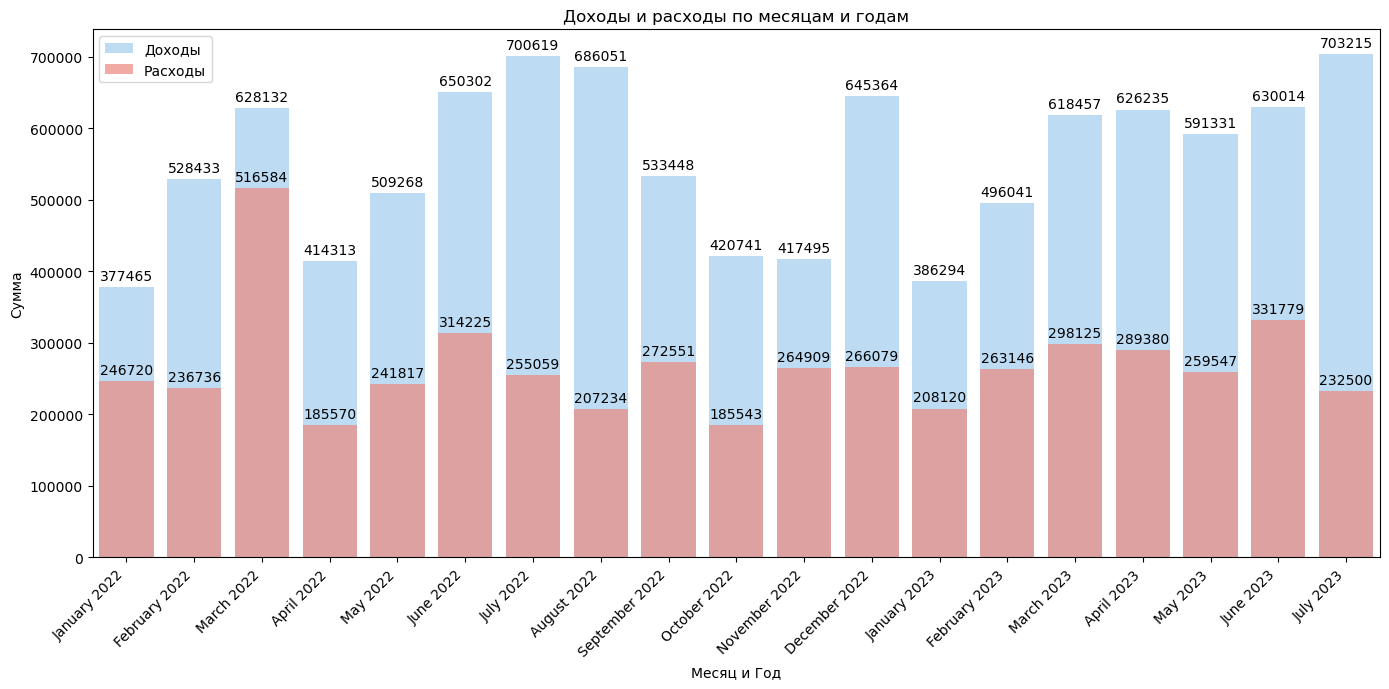

In [51]:
# Используем более приглушенные цвета для графика
blue_color = sns.xkcd_rgb["light blue"]
red_color = sns.xkcd_rgb["salmon"]

# Строим столбчатую диаграмму с двумя столбцами на месяц
plt.figure(figsize=(14, 7))
ax = sns.barplot(x='month_year', y='сумма', data=merged_income, label='Доходы', color=blue_color, alpha=0.7, linewidth=2)
sns.barplot(x='month_year', y='стоимость', data=merged_income, label='Расходы', color=red_color, alpha=0.7, linewidth=2)
plt.xlabel('Месяц и Год')
plt.ylabel('Сумма')
plt.title('Доходы и расходы по месяцам и годам')
plt.legend()

# Устанавливаем угол наклона надписей и увеличиваем дистанцию между месяцами
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xticks(range(len(merged_income)))
ax.set_xticklabels(merged_income['month_year'])

# Добавляем числовые значения над столбцами
for p1, p2, value1, value2 in zip(ax.patches[:len(merged_income)], ax.patches[len(merged_income):], merged_income['сумма'], merged_income['стоимость']):
    ax.annotate(f"{int(value1)}",
                (p1.get_x() + p1.get_width() / 2., p1.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')
    
    ax.annotate(f"{int(value2)}",
                (p2.get_x() + p2.get_width() / 2., p2.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

plt.tight_layout()
plt.show()

**Промежуточный итог:**  
* Самый высокий доход фиксируется в июле 2023 года
* Самый высокий расход в марте 2022 года
* Апрели 2022 и 2023 сильно отличаются.

### Чистая прибыль


In [52]:
# Вычисляем чистый доход как разницу между доходами и расходами
merged_income['чистый_доход'] = merged_income['сумма'] - merged_income['стоимость']

In [53]:
merged_income

,year,month,сумма,стоимость,month_year,чистый_доход
0,2022,1,377465.0,246720.750000,January 2022,130744.250000
1,2022,2,528433.5,236736.430000,February 2022,291697.070000
2,2022,3,628132.0,516584.422500,March 2022,111547.577500
3,2022,4,414313.0,185570.437500,April 2022,228742.562500
4,2022,5,509268.0,241817.531480,May 2022,267450.468520
5,2022,6,650302.0,314225.545000,June 2022,336076.455000
6,2022,7,700619.0,255059.820000,July 2022,445559.180000
7,2022,8,686051.0,207234.000000,August 2022,478817.000000
8,2022,9,533448.0,272551.385000,September 2022,260896.615000
9,2022,10,420741.0,185543.532500,October 2022,235197.467500


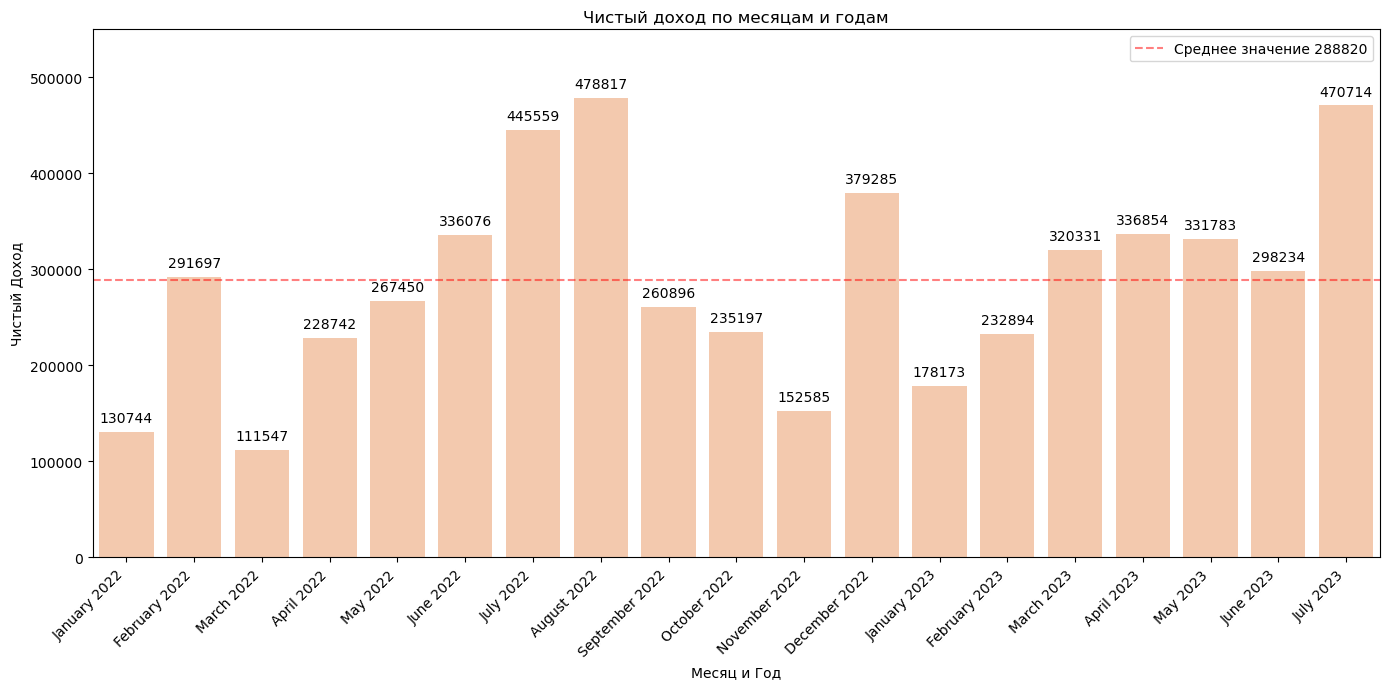

In [54]:
# Используем мягкий оранжевый цвет для графика
orange_color = sns.xkcd_rgb["peach"]

# Строим столбчатую диаграмму для чистого дохода
plt.figure(figsize=(14, 7))
ax = sns.barplot(x='month_year', y='чистый_доход', data=merged_income, color=orange_color, alpha=0.7, linewidth=2)
plt.xlabel('Месяц и Год')
plt.ylabel('Чистый Доход')
plt.title('Чистый доход по месяцам и годам')

# Устанавливаем угол наклона надписей и увеличиваем дистанцию между месяцами
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xticks(range(len(merged_income)))
ax.set_xticklabels(merged_income['month_year'])

# Добавляем числовые значения над столбцами
for p, value in zip(ax.patches, merged_income['чистый_доход']):
    ax.annotate(f"{int(value)}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

# Вычисляем среднее значение чистого дохода
mean_clean_income = merged_income['чистый_доход'].mean()

# Добавляем красную прерывистую линию среднего значения
plt.axhline(mean_clean_income, color='red', linestyle='--', alpha=0.5, label=f'Среднее значение {int(mean_clean_income)}')
# Задаем высоту отображаемой оси Y до 550000
ax.set_ylim(0, 550000)
# Включаем легенду
plt.legend()

plt.tight_layout()
plt.show()

In [55]:
merged_income['чистый_доход'].sum()

5487585.443520408

In [56]:
merged_income['чистый_доход'].mean()

288820.2865010741

In [57]:
merged_income['чистый_доход'].median()

291697.07

**Промежуточный итог:**  
* Чистый доход наибольший в августе 2022 июли 2022 и 2023 могут посоперничать с ним
* Наименьшая прибыль в марте 2022
* Марты 2022 и 2023 сильно отличаются. 
* Наилучший показатель чистого дохода показывает август 2022 года с 478 817 рублями.
* Сравнить с августом 2023 мы не можем, т.к. нет данных, но июль 2023 идет вторым с 470714 рублями.
* 2023 год выглядит финансово более стабильным по чистому доходу. Отсутствуют перепады как в марте 2022 и начиная с марта 2023 все месяцы показывают цифры выше средних за наблюдаемый период.

### Общая масса изготовленного товара

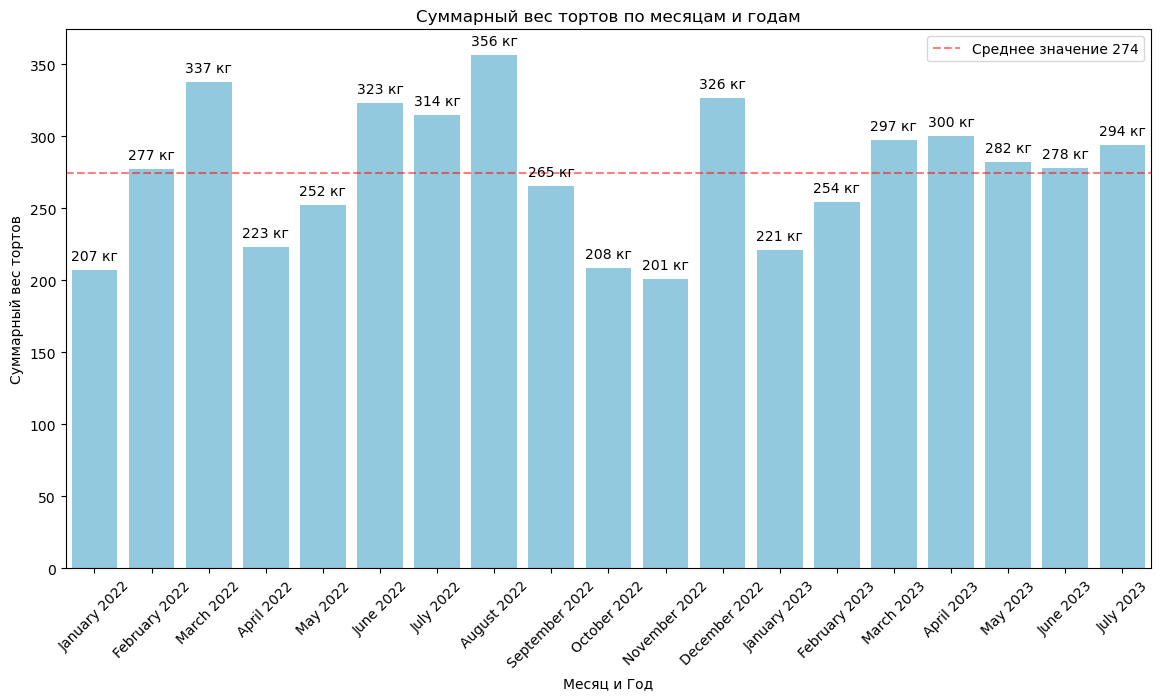

In [58]:
# Преобразуем столбец "вес" в числовой формат (если он содержит числа в виде строк)
income['вес'] = pd.to_numeric(income['вес'], errors='coerce')

# Группируем данные о доходах по месяцам и годам и суммируем вес тортов
cake_weight_monthly = income.groupby(['year', 'month'])['вес'].sum().reset_index()

# Создаем новый столбец с месяцами и годами в нужном формате
cake_weight_monthly['month_year'] = cake_weight_monthly['month'].apply(lambda x: calendar.month_name[x]) + ' ' + cake_weight_monthly['year'].astype(str)

# Строим столбчатую диаграмму
plt.figure(figsize=(14, 7))
ax = sns.barplot(x='month_year', y='вес', data=cake_weight_monthly, color='skyblue')
plt.xlabel('Месяц и Год')
plt.xticks(rotation=45)
plt.ylabel('Суммарный вес тортов')
plt.title('Суммарный вес тортов по месяцам и годам')

# Добавляем числовые значения над столбцами
for p, value in zip(ax.patches, cake_weight_monthly['вес']):
    ax.annotate(f"{int(value)} кг",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')
# Вычисляем среднее значение изготовленного продукта
mean_cake_weight_monthly = cake_weight_monthly['вес'].mean()

# Добавляем красную прерывистую линию среднего значения
plt.axhline(mean_cake_weight_monthly, color='red', linestyle='--', alpha=0.5, label=f'Среднее значение {int(mean_cake_weight_monthly)}')

# Включаем легенду
plt.legend()

plt.show()

In [59]:
cake_weight_monthly['вес'].sum()

5223.06

In [60]:
cake_weight_monthly['вес'].mean()

274.89789473684215

In [61]:
cake_weight_monthly['вес'].median()

278.1

**Промежуточный итог:**  
* Наибольшее количество продукта изготовлено в августе 2022 
* 2023 год выглядит довольно стабильным
* Довольно много изготовлено в декабре 2022

### Общее количество заказов

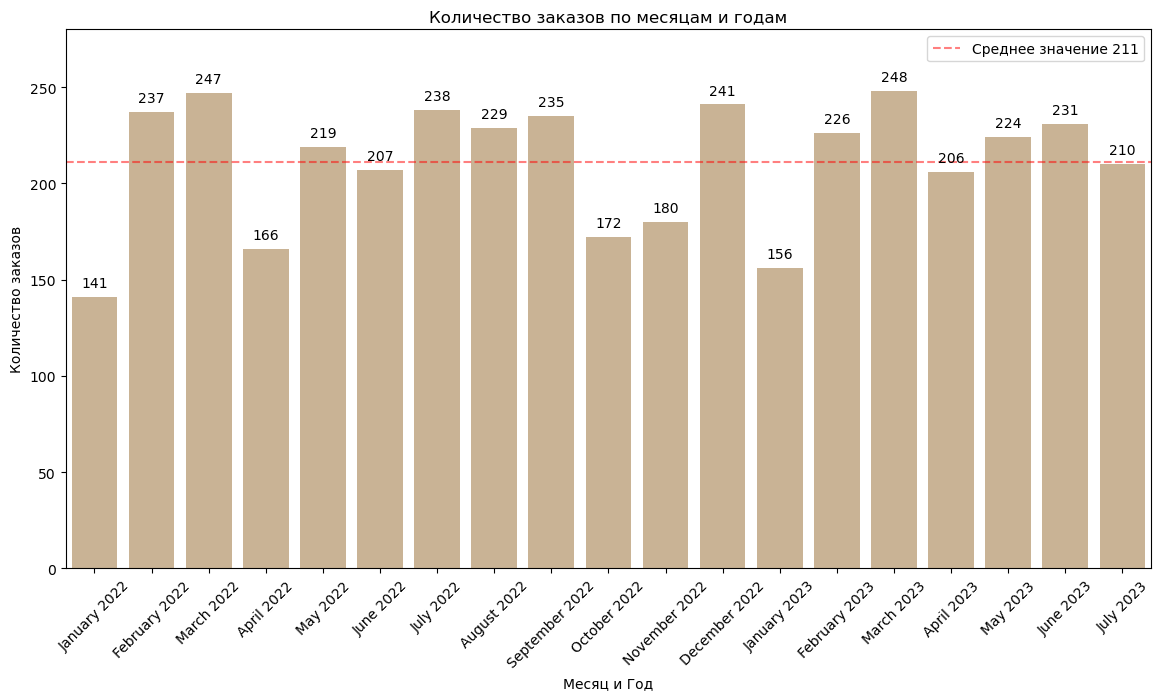

In [62]:
# Группируем данные о доходах по месяцам и годам и подсчитываем количество заказов
orders_per_month = income.groupby(['year', 'month']).size().reset_index(name='количество_заказов')

# Создаем новый столбец с месяцами и годами в нужном формате
orders_per_month['month_year'] = orders_per_month['month'].apply(lambda x: calendar.month_name[x]) + ' ' + orders_per_month['year'].astype(str)

# Строим столбчатую диаграмму
plt.figure(figsize=(14, 7))
ax = sns.barplot(x='month_year', y='количество_заказов', data=orders_per_month, color='tan')
plt.xlabel('Месяц и Год')
plt.xticks(rotation=45)
plt.ylabel('Количество заказов')
plt.title('Количество заказов по месяцам и годам')

# Добавляем числовые значения над столбцами
for p, value in zip(ax.patches, orders_per_month['количество_заказов']):
    ax.annotate(f"{int(value)}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

# Вычисляем среднее значение изготовленного продукта
mean_orders_per_month = orders_per_month['количество_заказов'].mean()

# Добавляем красную прерывистую линию среднего значения
plt.axhline(mean_orders_per_month, color='red', linestyle='--', alpha=0.5, label=f'Среднее значение {int(mean_orders_per_month)}')
# Задаем высоту отображаемой оси Y до 550000
ax.set_ylim(0, 280)
# Включаем легенду
plt.legend()
plt.show()

In [63]:
# Общее количество поступивших заказов в заданный период времени
orders_per_month['количество_заказов'].sum()

4013

In [64]:
# Медианное количество поступивших заказов в месяц
orders_per_month['количество_заказов'].median()

224.0

In [65]:
# Среднее количество поступивших заказов в месяц
orders_per_month['количество_заказов'].mean()

211.21052631578948

### Популярность начинок для торта
#### Подготовка таблиц для расчетов

In [66]:
# Группируем данные о доходах по месяцам, годам и начинкам, а затем суммируем вес тортов
cake_weight_by_flavor = income.groupby(['year', 'month', 'начинка'])['вес'].sum().reset_index()

# Создаем сводную таблицу, используя метод pivot_table
cake_weight_pivot = cake_weight_by_flavor.pivot_table(index=['year', 'month'], columns='начинка', values='вес', aggfunc='sum', fill_value=0).reset_index()

# Создаем столбец с месяцами и годами в нужном формате
cake_weight_pivot['month_year'] = cake_weight_pivot['month'].apply(lambda x: calendar.month_name[x]) + ' ' + cake_weight_pivot['year'].astype(str)

In [67]:
cake_weight_pivot

начинка,year,month,unknown,ассорти,бенто,бупешк,ванильный_бисквит,декор,кендибар,красный_бархат,...,птичье_молоко,радужный,сах.карт,свободный,сникерс,трайфлы,черничный,шарин,шоколадный,month_year
0,2022,1,13.5,3.0,0,0,16.5,0,0,22.0,...,0.0,2.5,0,0,5.0,0,0.0,0.0,22.0,January 2022
1,2022,2,19.0,13.0,0,0,17.5,0,0,27.5,...,2.0,2.5,0,0,8.0,0,0.0,0.0,14.5,February 2022
2,2022,3,0.0,29.0,0,0,30.3,0,0,27.8,...,3.7,0.0,0,0,7.0,0,2.0,0.0,18.0,March 2022
3,2022,4,0.0,43.0,0,0,18.0,0,0,26.7,...,0.0,0.0,0,0,0.0,0,5.5,0.0,20.0,April 2022
4,2022,5,0.5,30.0,0,0,27.7,0,0,10.0,...,3.0,0.0,0,0,4.5,0,3.5,0.0,15.0,May 2022
5,2022,6,0.0,87.0,0,0,42.5,0,0,27.5,...,0.0,0.0,0,0,10.5,0,2.0,0.0,29.0,June 2022
6,2022,7,1.8,32.0,0,0,27.0,0,0,21.5,...,0.0,0.0,0,0,0.0,0,6.0,0.0,27.5,July 2022
7,2022,8,4.0,21.5,0,0,35.0,0,0,40.0,...,0.0,0.0,0,0,3.5,0,3.0,0.0,19.0,August 2022
8,2022,9,1.0,27.0,0,0,33.0,0,0,15.0,...,0.0,0.0,0,0,6.0,0,6.0,0.0,37.0,September 2022
9,2022,10,0.0,44.0,0,0,37.5,0,0,10.5,...,0.0,0.0,0,0,2.0,0,0.0,0.0,14.5,October 2022


In [68]:
cake_weight_by_flavor

,year,month,начинка,вес
0,2022,1,unknown,13.5
1,2022,1,ассорти,3.0
2,2022,1,ванильный_бисквит,16.5
3,2022,1,красный_бархат,22.0
4,2022,1,манго,7.5
...,...,...,...,...
186,2023,7,медовый,172.1
187,2023,7,радужный,0.0
188,2023,7,сникерс,5.5
189,2023,7,черничный,3.0


#### График производства начинок тортов за указанный период

In [69]:
all_fillings = income.pivot_table(index='начинка', aggfunc={'наименование': 'count', 'вес': 'sum'}, fill_value=0)
all_fillings.columns = ['суммарный_вес (кг)', 'количество_заказов']
all_fillings.reset_index(inplace=True)
all_fillings = all_fillings.sort_values(by='количество_заказов', ascending=False)
all_fillings

,начинка,суммарный_вес (кг),количество_заказов
9,медовый,2964.56,2037
1,ассорти,504.40,420
20,шоколадный,451.40,399
4,ванильный_бисквит,482.60,398
7,красный_бархат,447.30,392
0,unknown,89.30,190
16,сникерс,112.00,70
18,черничный,73.20,37
8,манго,58.70,32
12,птичье_молоко,14.70,9


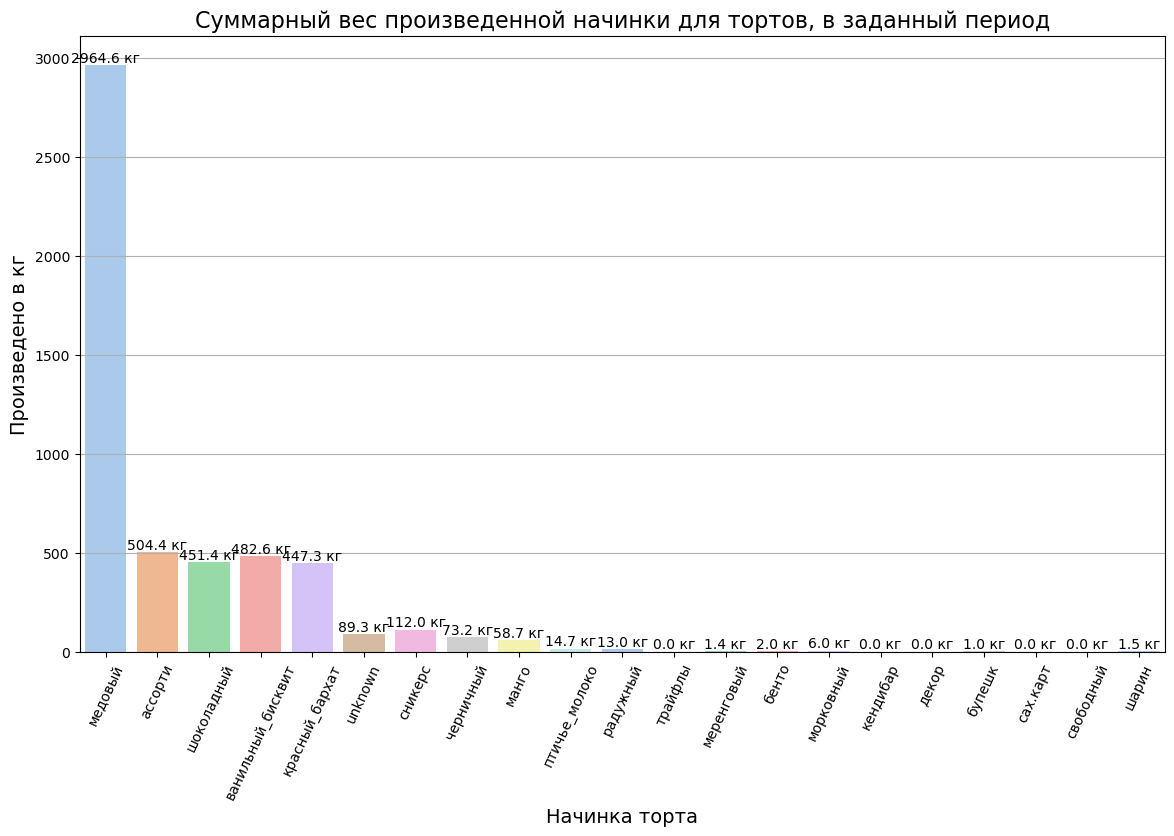

In [70]:
plt.figure(figsize=(14, 8)) 

fig = sns.barplot(x='начинка', y='суммарный_вес (кг)', data=all_fillings, palette='pastel')

plt.xlabel('Начинка торта', fontsize=14)
plt.ylabel('Произведено в кг', fontsize=14)
plt.title('Суммарный вес произведенной начинки для тортов, в заданный период', fontsize=16)

fig.set_xticklabels(fig.get_xticklabels(), rotation=65)
plt.grid(True, axis='y')

for p in fig.patches:
    height = p.get_height()
    plt.annotate(f"{height:.1f} кг",  # Округляем до одного знака после запятой и добавляем "кг"
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)  # Настройте размер шрифта по вашему усмотрению

plt.show()

**Промежуточный итог:**  
* За изучаемый период, а именно с января 2022 по июль 2023 года, медовая начинка является самой популярной. Её изготовили аж 2964.6 кг.
* Следом идут Ассорти (504.4 кг), Шоколадная (451 кг), Ванильный бисквит(482.6 кг), Красный бархат (447.3 кг)
* В итоге 5 первых позиций изготовлено почти 5 тон.


#### Медианное и среднее производство в месяц

In [71]:
cake_filling = (cake_weight_by_flavor.groupby('начинка')['вес']
             .agg(['median', 'mean'])
             .reset_index()
             .round({'median': 2, 'mean': 2})  # Уменьшаем число знаков после запятой до 2
             .query('(median != 0) & (mean != 0)')  # Удаляем строки с нулевыми значениями
             .sort_values(by='median', ascending=False))
cake_filling

,начинка,median,mean
9,медовый,150.41,156.03
1,ассорти,27.00,26.55
4,ванильный_бисквит,27.00,25.40
7,красный_бархат,23.50,23.54
20,шоколадный,22.00,23.76
16,сникерс,5.75,6.22
18,черничный,4.50,4.58
12,птичье_молоко,3.00,2.94
8,манго,2.75,3.26
13,радужный,2.50,2.17


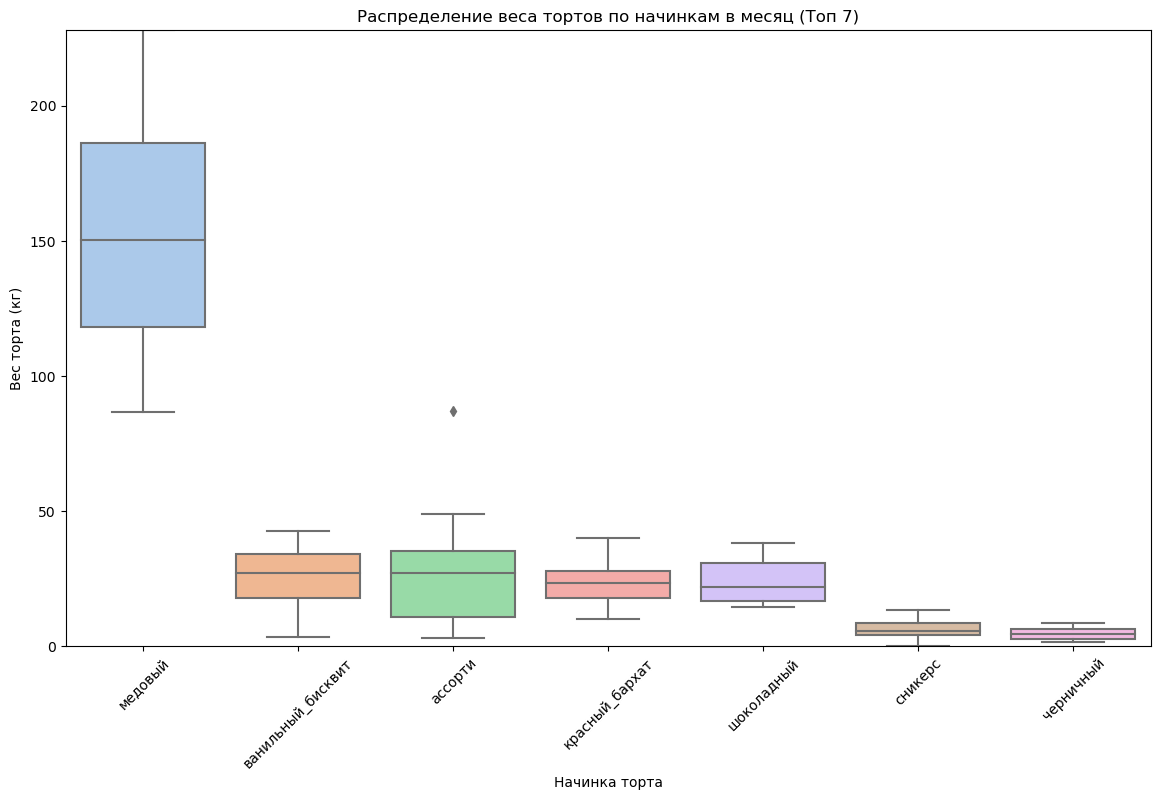

In [72]:
# Отсортируем начинки по медианному весу торта и возьмем первые 7
top_7_fillings_weight = cake_weight_by_flavor.groupby('начинка')['вес'].median().sort_values(ascending=False).head(7).index

# Устанавливаем пастельную палитру
sns.set_palette("pastel")

plt.figure(figsize=(14, 8))

# Фильтруем данные для отображения только топ 7 начинок
cake_weight_by_flavor_filtered = cake_weight_by_flavor[cake_weight_by_flavor['начинка'].isin(top_7_fillings_weight)]

sns.boxplot(data=cake_weight_by_flavor_filtered, x='начинка', y='вес', order=top_7_fillings_weight)
plt.xlabel('Начинка торта')
plt.ylabel('Вес торта (кг)')
plt.title('Распределение веса тортов по начинкам в месяц (Топ 7)')
plt.ylim([0, cake_weight_by_flavor_filtered['вес'].max()])  # Установите верхний предел графика в зависимости от максимального веса торта
plt.xticks(rotation=45)  # Поворачиваем метки по оси x для лучшей читаемости
plt.show()

**Промежуточный итог:**  
* В среднем в месяц изготавливается 156 кг медовой начинки, идущие следом 4 позиции от 22 кг до 27 кг

#### Количество заказов на начинки

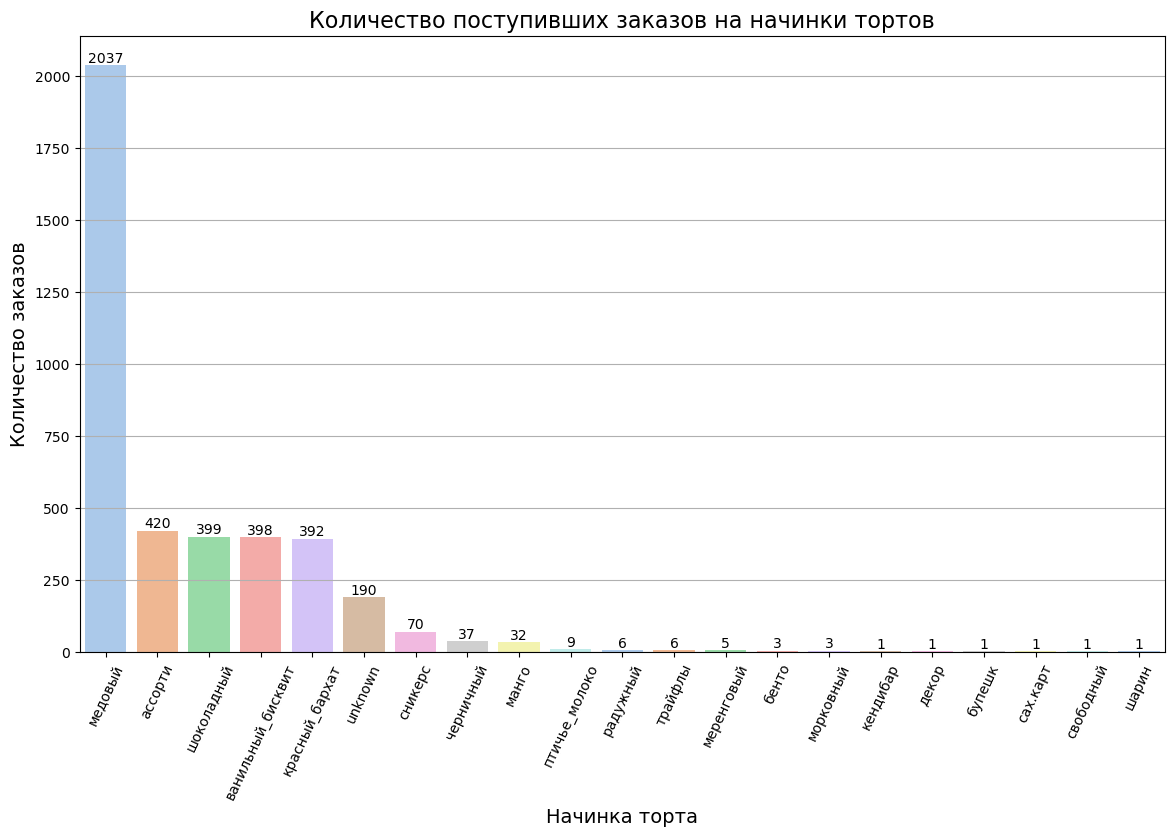

In [73]:
plt.figure(figsize=(14, 8)) 

fig = sns.barplot(x='начинка', y='количество_заказов', data=all_fillings, palette='pastel')

plt.xlabel('Начинка торта', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.title('Количество поступивших заказов на начинки тортов', fontsize=16)

fig.set_xticklabels(fig.get_xticklabels(), rotation=65)
plt.grid(True, axis='y')

for p in fig.patches:
    height = p.get_height()
    plt.annotate(f"{int(height)}",  # Убрали "кг" и округлили до целых
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)  # Настройте размер шрифта по вашему усмотрению

plt.show()

**Промежуточный итог:**  
* Наибольшее количество заказов поступило на медовую начинку 2037.
* Ассорти - 420, Шоколадный - 399, Ванильный Бисквит - 398, Красный Бархат - 392

In [74]:
cake_count_by_flavor = income.groupby(['year', 'month', 'начинка'])['наименование'].count().reset_index()
cake_filling_count = (cake_count_by_flavor.groupby('начинка')['наименование']
             .agg(['median', 'mean'])
             .reset_index()
             .round({'median': 2, 'mean': 2})  # Уменьшаем число знаков после запятой до 2
             .query('(median != 0) & (mean != 0)')  # Удаляем строки с нулевыми значениями
             .sort_values(by='median', ascending=False))
cake_filling_count

,начинка,median,mean
9,медовый,111.0,107.21
7,красный_бархат,22.0,20.63
1,ассорти,22.0,22.11
20,шоколадный,20.0,21.00
4,ванильный_бисквит,20.0,20.95
0,unknown,7.0,11.18
16,сникерс,4.0,3.89
10,меренговый,2.5,2.50
8,манго,2.0,1.78
12,птичье_молоко,2.0,1.80


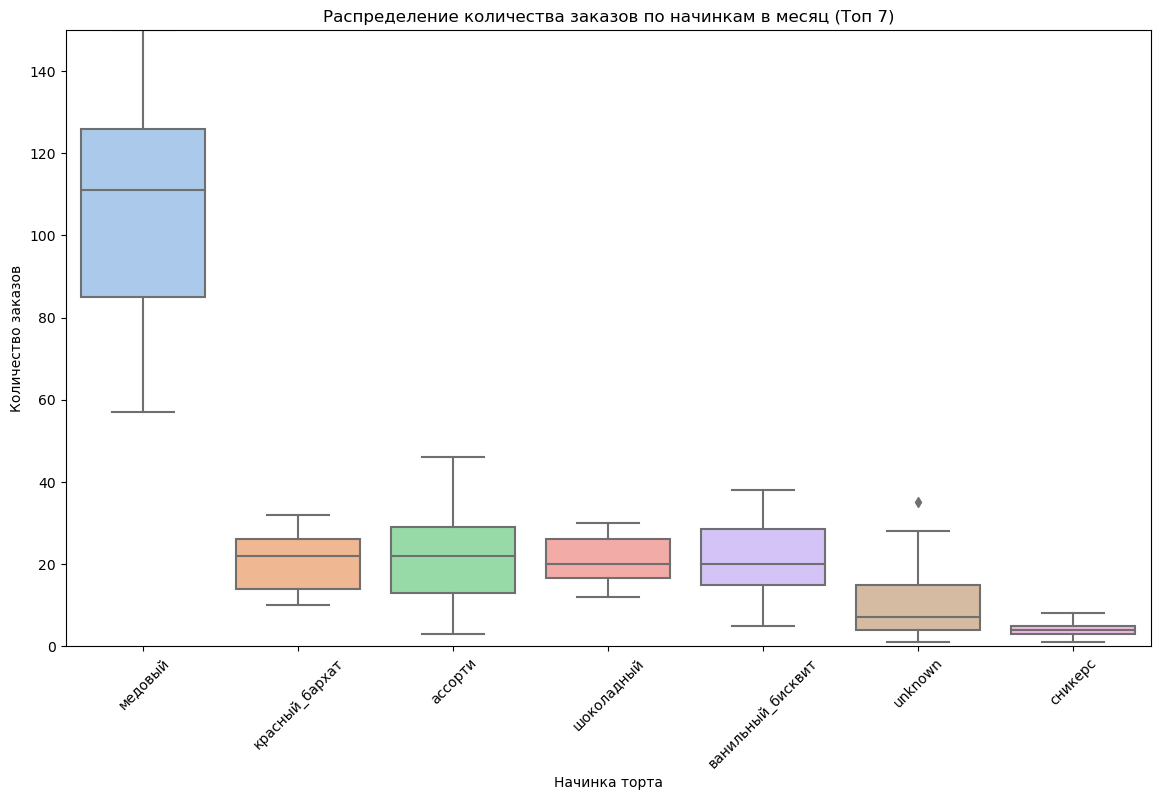

In [75]:
plt.figure(figsize=(14, 8))

# Отсортируем начинки по медианному количеству заказов и возьмем первые 7
top_7_fillings_count = cake_count_by_flavor.groupby('начинка')['наименование'].median().sort_values(ascending=False).head(7).index

# Устанавливаем пастельную палитру
sns.set_palette("pastel")

sns.boxplot(data=cake_count_by_flavor[cake_count_by_flavor['начинка'].isin(top_7_fillings_count)], x='начинка', y='наименование', order=top_7_fillings_count)
plt.xlabel('Начинка торта')
plt.ylabel('Количество заказов')
plt.title('Распределение количества заказов по начинкам в месяц (Топ 7)')
plt.ylim([0, cake_count_by_flavor['наименование'].max()])  # Установите верхний предел графика в зависимости от максимального количества заказов
plt.xticks(rotation=45)  # Поворачиваем метки по оси x для лучшей читаемости
plt.show()

**Промежуточный итог:**  
* В среднем медовую начинку заказывают 111 раз в месяц
* У идущих следом 4 позиций число заказов примерно 20

#### Доходы от начинок

In [76]:
fillings_revenue = income.groupby(['начинка'])['сумма'].sum().reset_index().sort_values(ascending=False, by='сумма')
fillings_revenue

,начинка,сумма
9,медовый,5692091.2
7,красный_бархат,984461.0
20,шоколадный,972804.0
4,ванильный_бисквит,971602.0
1,ассорти,924483.0
0,unknown,375534.5
16,сникерс,262962.0
18,черничный,135672.0
8,манго,134252.0
13,радужный,37330.0


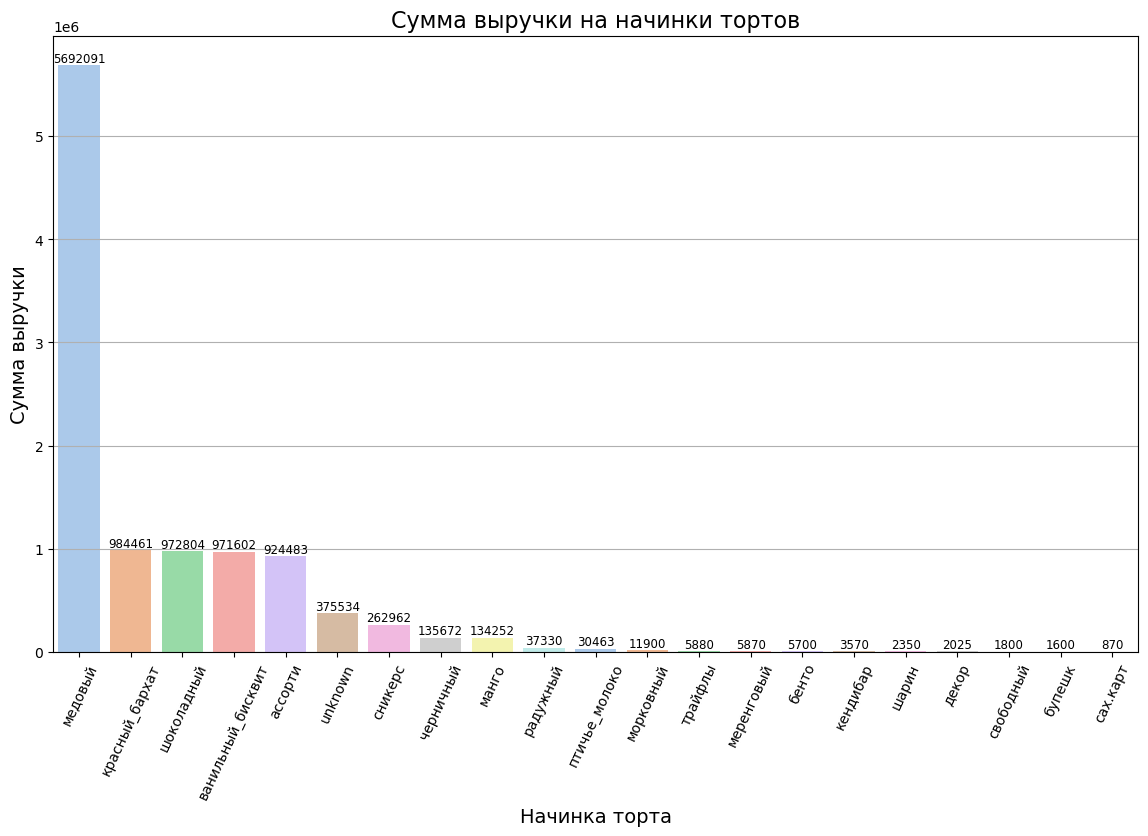

In [77]:
# Создаем график
plt.figure(figsize=(14, 8))
fig = sns.barplot(x='начинка', y='сумма', data=fillings_revenue, palette='pastel')  # Уменьшаем ширину столбцов

plt.xlabel('Начинка торта', fontsize=14)
plt.ylabel('Сумма выручки', fontsize=14)
plt.title('Сумма выручки на начинки тортов', fontsize=16)

fig.set_xticklabels(fig.get_xticklabels(), rotation=65)
plt.grid(True, axis='y')

for p in fig.patches:
    height = p.get_height()
    plt.annotate(f"{int(height)}",  # Убрали "кг" и округлили до целых
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=8.5)  # Настройте размер шрифта по вашему усмотрению

plt.show()

**Промежуточный итог:**  
* Наибольшую выручку приносит медовая начинка, за весь наблюдаемый период 5 692 091 рублей.
* Следом идут Красный бархат, шоколадный, ванильный бисквит, ассорти, у которых показатели примерно сопоставимы и выручка варьируется от 924 483 до 984 461 рублей.


In [78]:
cake_revenue_by_flavor = income.groupby(['year', 'month', 'начинка'])['сумма'].sum().reset_index()
cake_filling_revenue = (cake_revenue_by_flavor.groupby('начинка')['сумма']
             .agg(['median', 'mean'])
             .reset_index()
             .round({'median': 2, 'mean': 2})  # Уменьшаем число знаков после запятой до 2
             .query('(median != 0) & (mean != 0)')  # Удаляем строки с нулевыми значениями
             .sort_values(by='median', ascending=False))
cake_filling_revenue

,начинка,median,mean
9,медовый,290065.0,299583.75
7,красный_бархат,50714.0,51813.74
4,ванильный_бисквит,49493.0,51136.95
20,шоколадный,44785.0,51200.21
1,ассорти,43155.0,48657.00
16,сникерс,13135.0,14609.00
0,unknown,11950.0,22090.26
18,черничный,6925.0,8479.50
12,птичье_молоко,6665.0,6092.60
8,манго,6510.0,7458.44


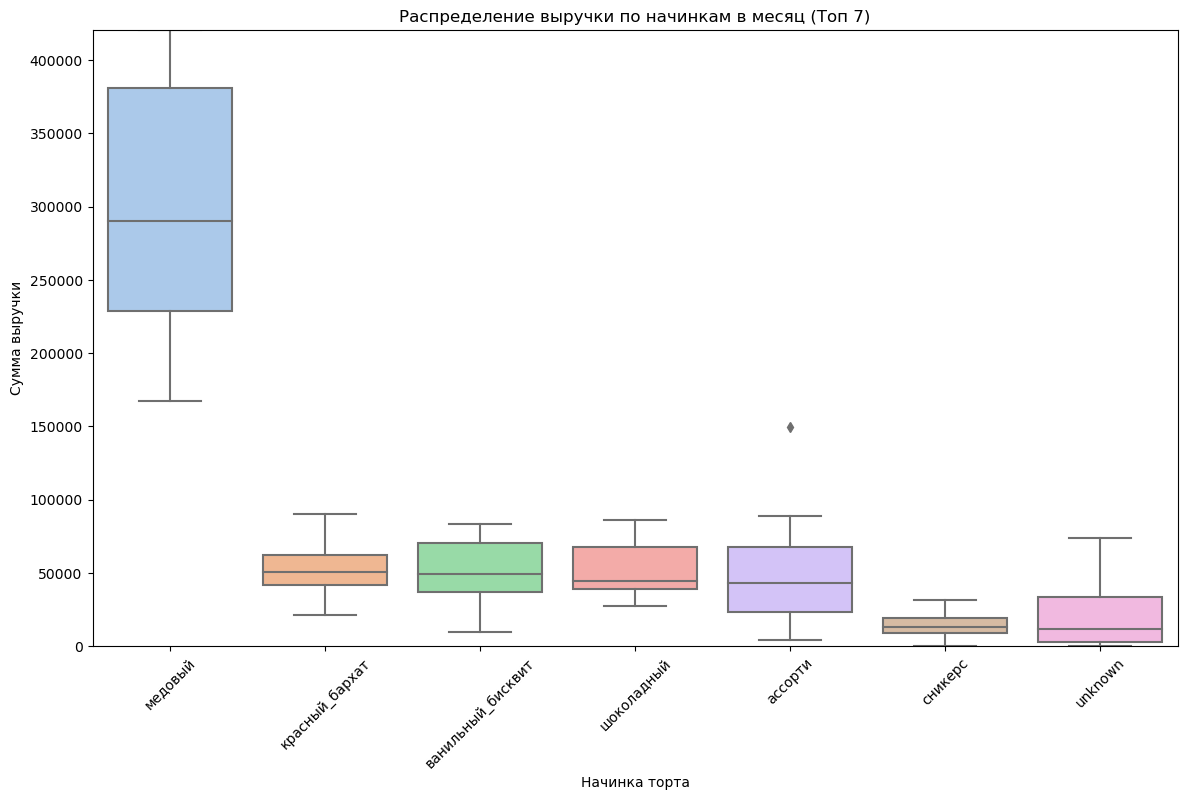

In [79]:
plt.figure(figsize=(14, 8))

# Отсортируем начинки по медианному количеству заказов и возьмем первые 7
top_7_fillings_revenue = cake_revenue_by_flavor.groupby('начинка')['сумма'].median().sort_values(ascending=False).head(7).index

# Устанавливаем пастельную палитру
sns.set_palette("pastel")

sns.boxplot(data=cake_revenue_by_flavor[cake_revenue_by_flavor['начинка'].isin(top_7_fillings_revenue)], x='начинка', y='сумма', order=top_7_fillings_revenue)
plt.xlabel('Начинка торта')
plt.ylabel('Сумма выручки')
plt.title('Распределение выручки по начинкам в месяц (Топ 7)')
plt.ylim([0, cake_revenue_by_flavor['сумма'].max()])  # Установите верхний предел графика в зависимости от максимального количества заказов
plt.xticks(rotation=45)  # Поворачиваем метки по оси x для лучшей читаемости
plt.show()

**Промужеточный итог:** 
* В среднем медовая начинка приносит в месяц 299 583 рублей в месяц, медианное значение составляет 290 065 рублей.
* Как и ранее самые распространенные начинки после медовой это красный бархат, ванильный бисквит, шоколадный и ассорти и их показатели снова близки друг к другу. 

### Взаимозависимость показателей


#### Средняя (медианная) стоимость заказа в месяц

In [80]:
# Группируем данные и вычисляем медиану и среднее значение
monthly_order_stats = income.groupby(['month_year'])['сумма'].agg(median='median', mean='mean').reset_index()
monthly_order_stats['mean'] = monthly_order_stats['mean'].round(2)
pivot_monthly_order_stats = pd.pivot_table(monthly_order_stats, index='month_year', values=['median', 'mean'])
pivot_monthly_order_stats.index = pivot_monthly_order_stats.index.strftime('%Y-%m')
pivot_monthly_order_stats = pivot_monthly_order_stats.rename(columns={'median': 'медианная', 'mean': 'средняя'})
pivot_monthly_order_stats

,средняя,медианная
month_year,,
2022-01,2677.06,2250.0
2022-02,2229.68,1500.0
2022-03,2543.04,1700.0
2022-04,2495.86,1700.0
2022-05,2325.42,1700.0
2022-06,3141.56,1700.0
2022-07,2943.78,2365.0
2022-08,2995.86,1700.0
2022-09,2269.99,1700.0


Text(0, 0.5, 'Значение')

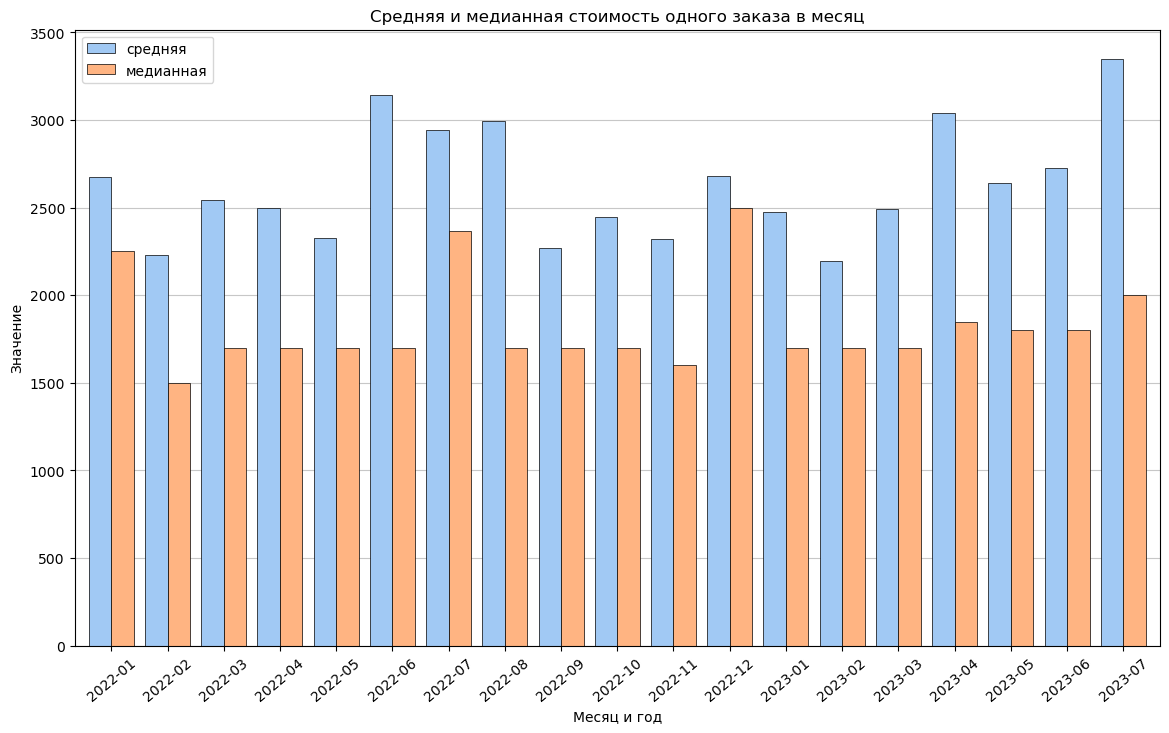

In [81]:
#Строим столбчатую диаграмму
ax = pivot_monthly_order_stats.plot.bar(figsize=(14, 8), use_index=True, width=0.8, edgecolor='black', linewidth=0.5)
ax.set_axisbelow(True)  
ax.grid(axis='y', alpha=0.7) 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40) 
plt.title('Средняя и медианная стоимость одного заказа в месяц')
plt.xlabel('Месяц и год')
plt.ylabel('Значение')

**Промежуточный итог:**  
* Средняя цена за торт в месяц фактически всегда выше чем медианная, это вызвано разбросом цен. Медианная здесь показывает цену большинства заказов, когда как средняя показывает распределение цены за месяц.
* Можно предположить, что в месяцы, когда разница между медианной и средней ценой за заказ становится более заметной или значительной, это может указывать на наличие значительных изменений в структуре цен или на появление значительных выбросов в ценообразовании за данный период. Т.е. если средняя цена сильно выше медианной, то мы можем предпологать, что в этом месяце поступали дорогие заказы (например заказ на большой юбилей или свадьбу).

#### Средняя (медианная) стоимость кг торта в месяц

In [82]:
income['цена_за_кг'] = income['сумма'] / income['вес']
monthly_price_stats = income.groupby(['month_year'])['цена_за_кг'].agg(median='median', mean='mean').reset_index()
monthly_price_stats['mean'] = monthly_price_stats['mean'].round(2)
monthly_price_stats['median'] = monthly_price_stats['median'].round(2)
pivot_monthly_price_stats = pd.pivot_table(monthly_price_stats, index='month_year', values=['median', 'mean'])
pivot_monthly_price_stats.index = pivot_monthly_price_stats.index.strftime('%Y-%m')
pivot_monthly_price_stats = pivot_monthly_price_stats.rename(columns={'median': 'медианная', 'mean': 'средняя'})
pivot_monthly_price_stats

,средняя,медианная
month_year,,
2022-01,1736.79,1650.83
2022-02,1785.91,1700.00
2022-03,1877.51,1700.00
2022-04,1772.49,1700.00
2022-05,1886.67,1800.00
2022-06,2030.68,1791.67
2022-07,2049.52,1900.00
2022-08,1908.42,1833.33
2022-09,1876.26,1879.25


Text(0, 0.5, 'Значение')

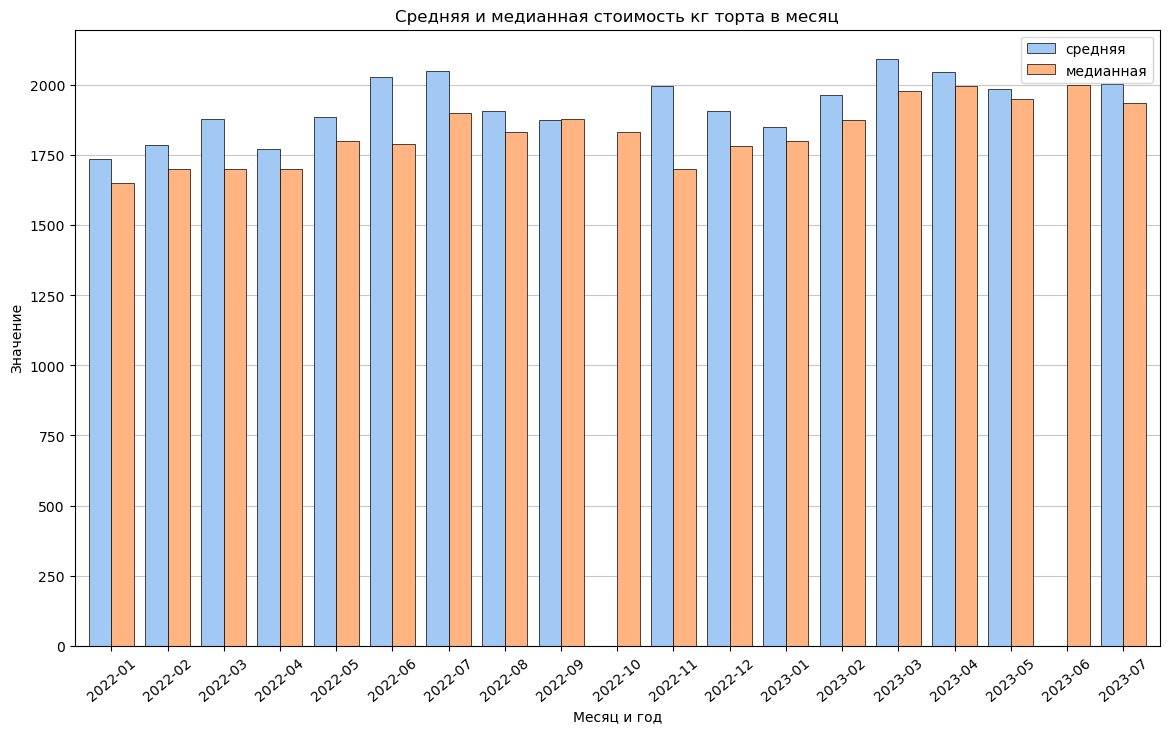

In [83]:
#Строим столбчатую диаграмму
ax = pivot_monthly_price_stats.plot.bar(figsize=(14, 8), use_index=True, width=0.8, edgecolor='black', linewidth=0.5)
ax.set_axisbelow(True)  
ax.grid(axis='y', alpha=0.7) 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40) 
plt.title('Средняя и медианная стоимость кг торта в месяц')
plt.xlabel('Месяц и год')
plt.ylabel('Значение')

**Промежуточный итог:**  
* Средняя и медианная цена за кг торта сильно не меняется от месяца к месяцу и остается достаточно стабильной.
* Средние и медианные не сильно различаются и примерно равны. Что свидетельствует о точности данных. 

### Формы оплаты

In [84]:
income['оплата'].nunique()

17

In [85]:
income['оплата'].unique()

array(['наличные', 'мобильный_банк', 'безналичный', 'в_долг_сотруднику',
       'unknown', 'тома', 'гюнель', 'зарплата', 'подарок', 'бартер',
       'кюннэй', 'мама', 'аннамария', 'ира', 'хкб', 'бесплатно',
       'выиграла'], dtype=object)

**Промежуточный итог:**  
* У нас имеется  17 уникальных форм оплаты в таблице

#### Количество заказов на способ оплаты

In [86]:
# Создаем таблицу с количеством оплат и сортируем ее
payment_counts = pd.pivot_table(income, index='оплата', values='сумма', aggfunc='count').reset_index()
payment_counts = payment_counts.rename(columns={'сумма': 'количество оплат'})
payment_counts = payment_counts.sort_values(by='количество оплат', ascending=False)

# Добавляем столбец с процентами
total_orders = payment_counts['количество оплат'].sum()
payment_counts['доля в %'] = ((payment_counts['количество оплат'] / total_orders) * 100).round(2)
payment_counts

,оплата,количество оплат,доля в %
12,мобильный_банк,3077,76.68
13,наличные,506,12.61
0,unknown,332,8.27
5,в_долг_сотруднику,41,1.02
3,безналичный,38,0.95
2,бартер,4,0.10
11,мама,2,0.05
15,тома,2,0.05
8,зарплата,2,0.05
1,аннамария,2,0.05


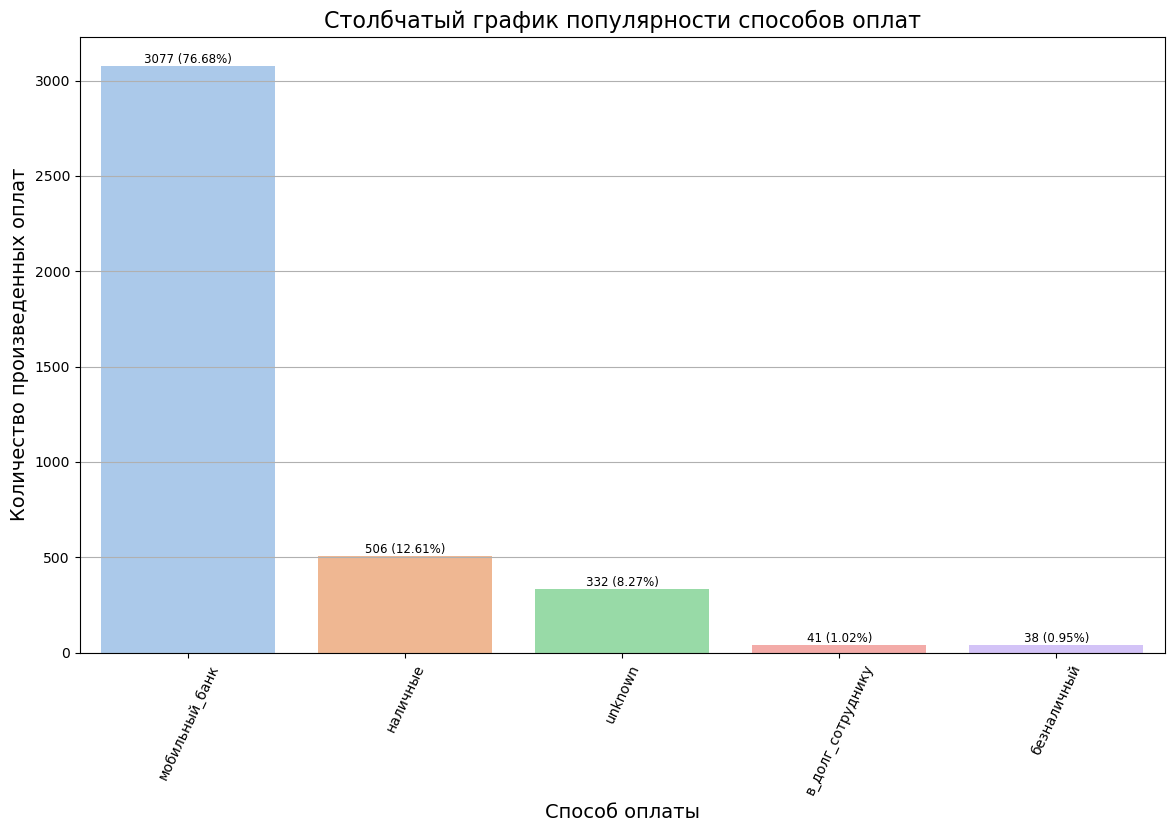

In [87]:
# Создаем график
plt.figure(figsize=(14, 8))
fig = sns.barplot(x='оплата', y='количество оплат', data=payment_counts.head(5), palette='pastel')  # Уменьшаем ширину столбцов

plt.xlabel('Способ оплаты', fontsize=14)
plt.ylabel('Количество произведенных оплат', fontsize=14)
plt.title('Столбчатый график популярности способов оплат', fontsize=16)

fig.set_xticklabels(fig.get_xticklabels(), rotation=65)
plt.grid(True, axis='y')

# Добавляем числовые значения и проценты в скобках над столбцами
for p, percent in zip(fig.patches, payment_counts.head(5)['доля в %']):
    height = p.get_height()
    plt.annotate(f"{int(height)} ({percent:.2f}%)",  # Добавляем проценты
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=8.5)

plt.show()

**Промежуточный итог:**  
* Самым популярным способов оплаты являеться мобильный перевод, он же мобильный банк. Таким способов расплатились за 3077 заказов, т.е. в 76.68% случаев.
* Немного пугающим является что мы не занем каким образом производилось аж 332 всех оплат, а это 8.27% всех транзакций. 

#### Сумма выплат за форму оплаты

In [88]:
# Создаем таблицу с количеством оплат и сортируем ее
payment_sum = pd.pivot_table(income, index='оплата', values='сумма', aggfunc='sum').reset_index()
payment_sum = payment_sum.rename(columns={'сумма': 'выручка'})
payment_sum = payment_sum.sort_values(by='выручка', ascending=False)

# Добавляем столбец с процентами
total_orders_sum = payment_sum['выручка'].sum()
payment_sum['доля в %'] = ((payment_sum['выручка'] / total_orders_sum) * 100).round(2)
payment_sum

,оплата,выручка,доля в %
12,мобильный_банк,8126583.0,76.93
13,наличные,1539525.2,14.57
0,unknown,683872.0,6.47
3,безналичный,126404.0,1.20
5,в_долг_сотруднику,65011.0,0.62
16,хкб,9945.0,0.09
1,аннамария,4720.0,0.04
11,мама,2520.0,0.02
15,тома,1934.0,0.02
8,зарплата,792.0,0.01


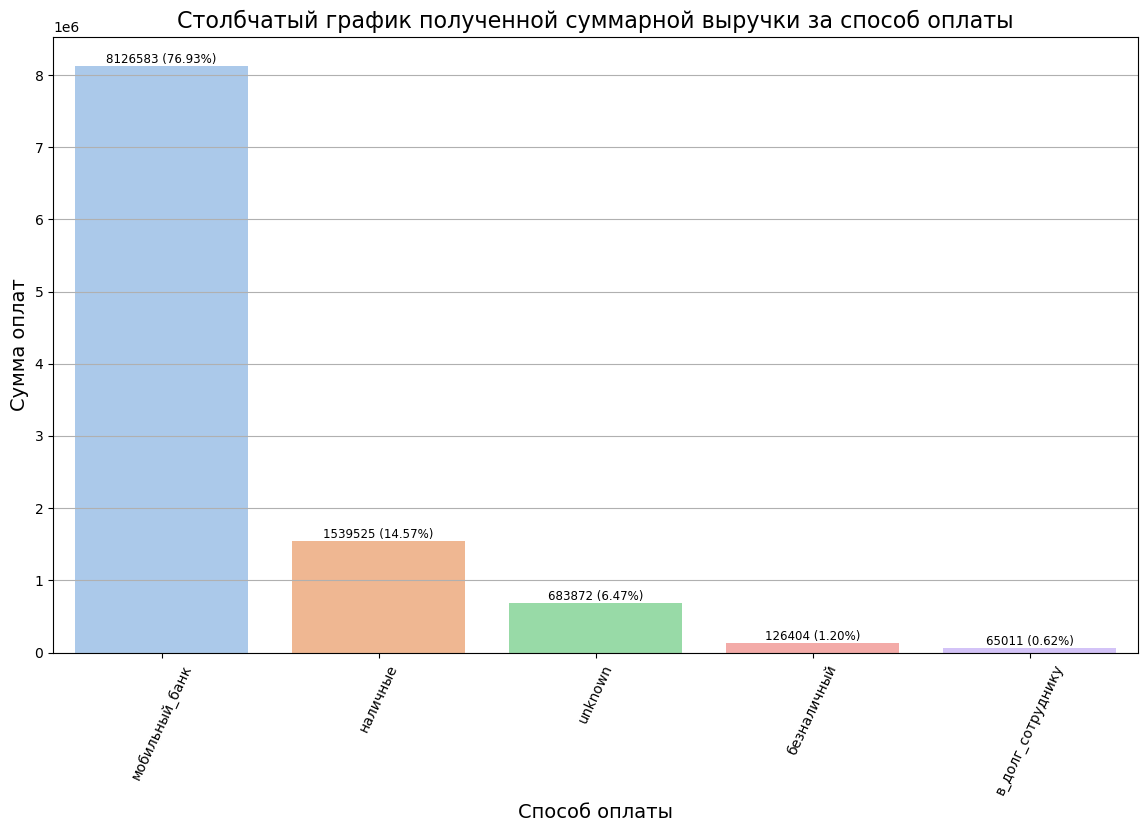

In [89]:
# Создаем график
plt.figure(figsize=(14, 8))
fig = sns.barplot(x='оплата', y='выручка', data=payment_sum.head(5), palette='pastel')  # Уменьшаем ширину столбцов

plt.xlabel('Способ оплаты', fontsize=14)
plt.ylabel('Сумма оплат', fontsize=14)
plt.title('Столбчатый график полученной суммарной выручки за способ оплаты', fontsize=16)

fig.set_xticklabels(fig.get_xticklabels(), rotation=65)
plt.grid(True, axis='y')

# Добавляем числовые значения и проценты в скобках над столбцами
for p, percent in zip(fig.patches, payment_sum.head(5)['доля в %']):
    height = p.get_height()
    plt.annotate(f"{int(height)} ({percent:.2f}%)",  # Добавляем проценты
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=8.5)

plt.show()

**Промежуточный итог:**  
* Сумма поступивших средств путем мобильного перевода так же значительно выше других источников и его доля составляет 76.93%, т.е. 8 126 583 рубля.
* Наличные поступления в кассу составили 14.57%, т.е. 1 539 525 рублей.
* Неизвестный источник, т.е. не указанный в таблице каким образом поступишвие средства, составили 6.47% средст, т.е. 683 872 рубля.
* Безналичный расчет крайне редкая форма (к удивлению), и составила только 1.20%, т.е. 126 404  рубля.
* Сотрудники компании не так часто скупали собственную продукцию и их доля составила 0.62%, т.е. 65 011 рубля.
* Остальные источники не превышают и десятой доли процента.